In [85]:
import pandas as pd


In [86]:
pip install pandas

# ML

In [87]:
pip install matplotlib


Note: you may need to restart the kernel to use updated packages.


In [88]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [21]:
import pandas as pd

# โหลดข้อมูล
df = pd.read_excel("df_final_clean.xlsx")
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# รวมข้อมูลรายเดือน-อำเภอ
monthly = df.groupby(['อำเภอ', 'year', 'month'], as_index=False).agg({
    'cases': 'sum',
    'temp_15d_avg': 'mean',
    'rain_15d_avg': 'mean',
    'humid_15d_avg': 'mean'
})

# เรียงลำดับเวลา
monthly = monthly.sort_values(['อำเภอ', 'year', 'month']).reset_index(drop=True)

# บันทึกไฟล์ใหม่
monthly.to_excel("df_monthly_grouped.xlsx", index=False)


In [22]:
import pandas as pd

# โหลดข้อมูลรายเดือน
df = pd.read_excel("df_monthly_grouped.xlsx")

# เรียงข้อมูลก่อน
df = df.sort_values(['อำเภอ', 'year', 'month']).reset_index(drop=True)

# สร้าง lag 1–3 เดือน
for k in [1, 2, 3]:
    df[f'cases_lag{k}'] = df.groupby('อำเภอ')['cases'].shift(k)

# ลบแถวที่มี NaN จาก lag
df = df.dropna().reset_index(drop=True)

df.to_excel("df_with_lag.xlsx", index=False)


In [23]:
import pandas as pd
import numpy as np

# ===================== 1. โหลดข้อมูลดิบ =====================
df = pd.read_excel("df_final_clean.xlsx")
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# ✅ ไตรมาส
df['quarter'] = ((df['month'] - 1) // 3) + 1

# ===================== 2. รวมข้อมูลรายเดือน-อำเภอ =====================
# cases, temp, rain, humid → sum / mean
agg_base = df.groupby(['อำเภอ','year','month'], as_index=False).agg({
    'cases': 'sum',
    'temp_15d_avg': 'mean',
    'rain_15d_avg': 'mean',
    'humid_15d_avg': 'mean'
})

# ===================== 3. เพศ → สัดส่วนชาย =====================
male_ratio = df.groupby(['อำเภอ','year','month'])['เพศ']\
    .apply(lambda x: (x == 'ชาย').mean()).reset_index(name='male_ratio')

# ===================== 4. อายุ → ค่าเฉลี่ย =====================
age_mean = df.groupby(['อำเภอ','year','month'])['อายุ(ปี)']\
    .mean().reset_index(name='age_mean')

# ===================== 5. อาชีพ → สัดส่วน top categories =====================
# นับจำนวนแต่ละอาชีพต่อเดือน
occ_counts = df.groupby(['อำเภอ','year','month','อาชีพ']).size().reset_index(name='count')

# หาผลรวมทั้งหมดในเดือนนั้น เพื่อคิดสัดส่วน
occ_total = occ_counts.groupby(['อำเภอ','year','month'])['count'].transform('sum')
occ_counts['ratio'] = occ_counts['count'] / occ_total

# Pivot wide → one-hot occupation ratios
occ_pivot = occ_counts.pivot_table(
    index=['อำเภอ','year','month'],
    columns='อาชีพ',
    values='ratio',
    fill_value=0
).reset_index()

# ✅ เปลี่ยนชื่อคอลัมน์ให้ไม่มี space
occ_pivot.columns = [f"occ_{c}" if c not in ['อำเภอ','year','month'] else c for c in occ_pivot.columns]

# ===================== 6. ตำบล → จำนวนตำบลที่มีรายงานผู้ป่วย =====================
n_subdistrict = df.groupby(['อำเภอ','year','month'])['ตำบล']\
    .nunique().reset_index(name='n_subdistricts')

# ===================== 7. รวมทุกส่วน =====================
merged = agg_base.merge(male_ratio, on=['อำเภอ','year','month'], how='left')
merged = merged.merge(age_mean, on=['อำเภอ','year','month'], how='left')
merged = merged.merge(occ_pivot, on=['อำเภอ','year','month'], how='left')
merged = merged.merge(n_subdistrict, on=['อำเภอ','year','month'], how='left')

# ✅ เพิ่ม quarter
merged['quarter'] = ((merged['month'] - 1)//3) + 1

# เรียงตามเวลา
merged = merged.sort_values(['อำเภอ','year','month']).reset_index(drop=True)

# ===================== 8. สร้าง Lag 1–3 เดือน =====================
for k in [1, 2, 3]:
    merged[f'cases_lag{k}'] = merged.groupby('อำเภอ')['cases'].shift(k)

# ลบ NaN ที่เกิดจาก lag
merged = merged.dropna().reset_index(drop=True)

# ✅ บันทึกไฟล์ใหม่
merged.to_excel("df_monthly_full_variables.xlsx", index=False)
print("✅ Data prepared with full variables:", merged.shape)


✅ Data prepared with full variables: (302, 25)


📊 Improved Model Performance:
✅ RMSE: 14.10
✅ MAE : 7.00
✅ R²  : 0.611


C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


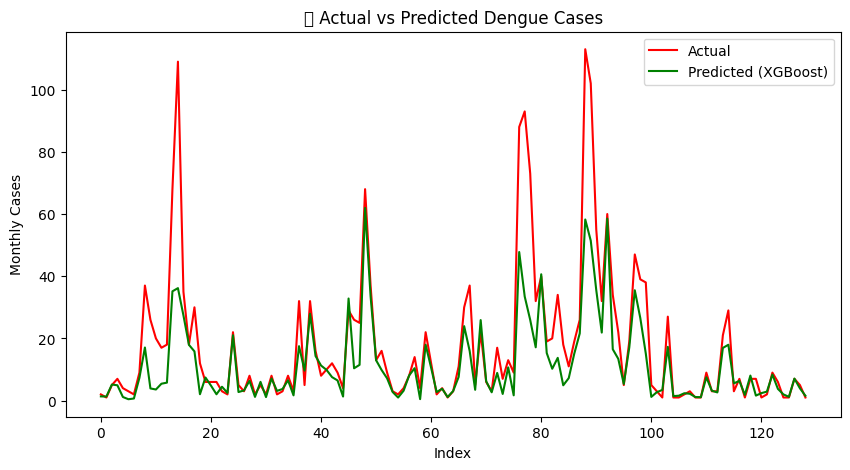

In [37]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------- 1. Load & Prepare Data -------------------
df = pd.read_excel("df_final_clean.xlsx")
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# รวมข้อมูลรายเดือนต่ออำเภอ
agg_df = df.groupby(['อำเภอ', 'year', 'month']).agg({
    'cases': 'sum',
    'temp_15d_avg': 'mean',
    'rain_15d_avg': 'mean',
    'humid_15d_avg': 'mean',
    'เพศ': 'count',  # จำนวนผู้ป่วย
    'อายุ(ปี)': 'mean'
}).rename(columns={'เพศ': 'n_cases', 'อายุ(ปี)': 'age_mean'}).reset_index()

# ------------------- 2. Feature Engineering -------------------
# (a) Lag features
agg_df = agg_df.sort_values(['อำเภอ', 'year', 'month'])
agg_df['cases_lag1'] = agg_df.groupby('อำเภอ')['cases'].shift(1)
agg_df['cases_lag3'] = agg_df.groupby('อำเภอ')['cases'].shift(3)
agg_df['cases_lag6'] = agg_df.groupby('อำเภอ')['cases'].shift(6)
agg_df['cases_lag12'] = agg_df.groupby('อำเภอ')['cases'].shift(12)

# (b) Rolling mean
agg_df['cases_roll3'] = agg_df.groupby('อำเภอ')['cases'].transform(lambda x: x.rolling(window=3).mean())
agg_df['cases_roll6'] = agg_df.groupby('อำเภอ')['cases'].transform(lambda x: x.rolling(window=6).mean())

# (c) Difference (trend)
agg_df['cases_diff1'] = agg_df.groupby('อำเภอ')['cases'].diff(1)

# (d) Climate interaction
agg_df['temp_rain_interaction'] = agg_df['temp_15d_avg'] * agg_df['rain_15d_avg']
agg_df['rain_humid_interaction'] = agg_df['rain_15d_avg'] * agg_df['humid_15d_avg']

# ------------------- 3. Categorical Encoding (District) -------------------
agg_df = pd.get_dummies(agg_df, columns=['อำเภอ'], drop_first=True)

# ------------------- 4. Drop NA -------------------
agg_df = agg_df.dropna().reset_index(drop=True)

# ------------------- 5. Feature Selection -------------------
target = 'cases'
num_features = [
    'temp_15d_avg', 'rain_15d_avg', 'humid_15d_avg', 'age_mean', 'n_cases',
    'cases_lag1', 'cases_lag3', 'cases_lag6', 'cases_lag12',
    'cases_roll3', 'cases_roll6', 'cases_diff1',
    'temp_rain_interaction', 'rain_humid_interaction'
]
cat_features = [c for c in agg_df.columns if c.startswith('อำเภอ_')]
features = num_features + cat_features

X = agg_df[features]
y = agg_df[target]

# ------------------- 6. Train/Test Split by Time -------------------
train_df = agg_df[agg_df['year'] < 2023]
test_df = agg_df[agg_df['year'] >= 2023]

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

# ------------------- 7. Train XGBoost (Tuned) -------------------
xgb_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# ------------------- 8. Evaluate -------------------
y_pred = xgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("📊 Improved Model Performance:")
print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ MAE : {mae:.2f}")
print(f"✅ R²  : {r2:.3f}")

# ------------------- 9. Visualization -------------------
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label='Actual', color='red')
plt.plot(y_pred, label='Predicted (XGBoost)', color='green')
plt.title('📈 Actual vs Predicted Dengue Cases')
plt.xlabel('Index')
plt.ylabel('Monthly Cases')
plt.legend()
plt.show()


📊 Model Performance (Full Features):
✅ RMSE: 13.80
✅ MAE : 6.77
✅ R²  : 0.627


C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


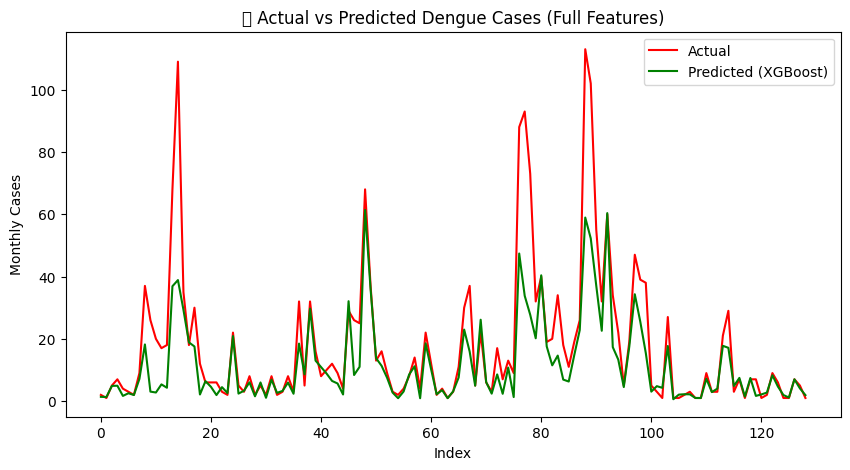

C:\Users\USER\AppData\Local\Temp\ipykernel_22864\2595642532.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='feature', x='importance', data=importance_df.head(20), palette='viridis')
C:\Users\USER\AppData\Local\Temp\ipykernel_22864\2595642532.py:125: UserWarning: Glyph 3629 (\N{THAI CHARACTER O ANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_22864\2595642532.py:125: UserWarning: Glyph 3634 (\N{THAI CHARACTER SARA AA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_22864\2595642532.py:125: UserWarning: Glyph 3594 (\N{THAI CHARACTER CHO CHANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_22864\2595642532.py:125: UserWarning: Glyph 3637 (\N{THAI CHARACTER SARA II}) missing f

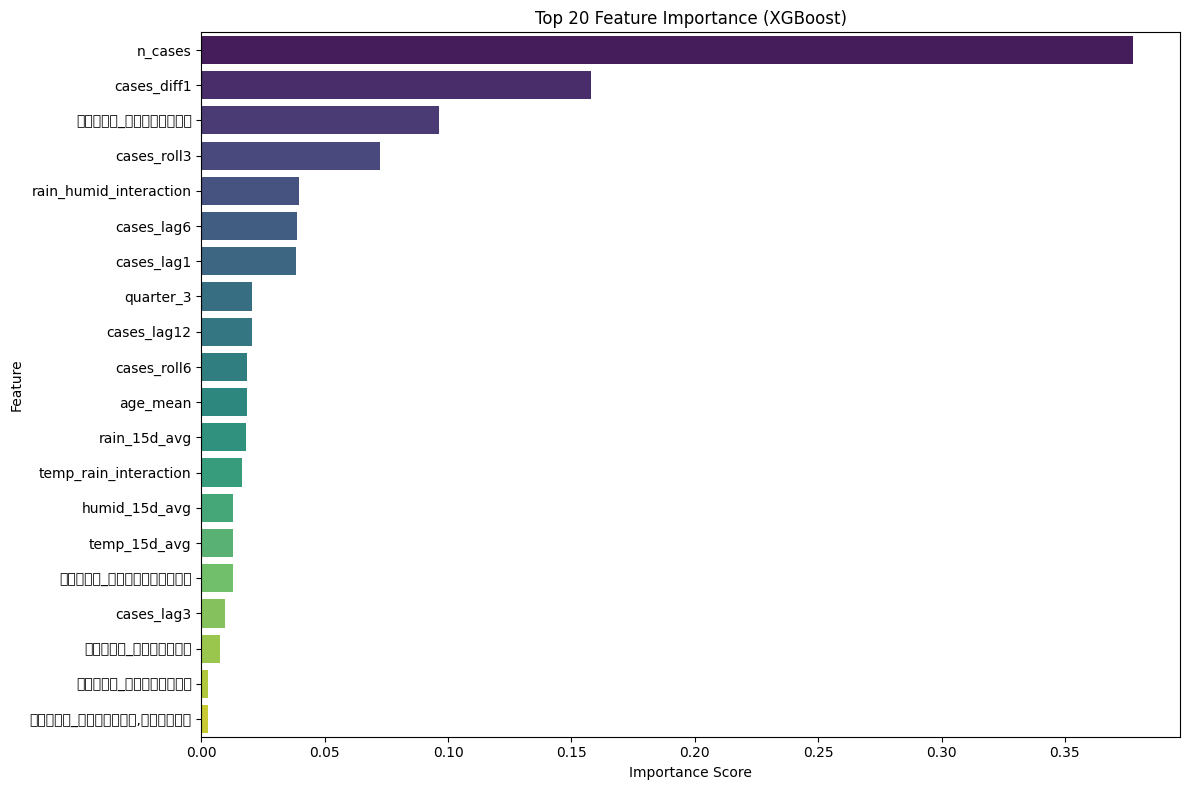

In [33]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------- 1. Load & Prepare Data -------------------
df = pd.read_excel("df_final_clean.xlsx")
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# ------------------- 2. Aggregate Monthly per District -------------------
agg_df = df.groupby(['อำเภอ', 'year', 'month']).agg({
    'cases': 'sum',
    'temp_15d_avg': 'mean',
    'rain_15d_avg': 'mean',
    'humid_15d_avg': 'mean',
    'เพศ': 'count',
    'อายุ(ปี)': 'mean',
    'อาชีพ': lambda x: x.mode()[0] if not x.mode().empty else 'ไม่ทราบ'
}).rename(columns={'เพศ': 'n_cases', 'อายุ(ปี)': 'age_mean'}).reset_index()

# ------------------- 3. Temporal Features -------------------
agg_df = agg_df.sort_values(['อำเภอ', 'year', 'month'])

for lag in [1, 3, 6, 12]:
    agg_df[f'cases_lag{lag}'] = agg_df.groupby('อำเภอ')['cases'].shift(lag)

agg_df['cases_roll3'] = agg_df.groupby('อำเภอ')['cases'].transform(lambda x: x.rolling(3).mean())
agg_df['cases_roll6'] = agg_df.groupby('อำเภอ')['cases'].transform(lambda x: x.rolling(6).mean())
agg_df['cases_diff1'] = agg_df.groupby('อำเภอ')['cases'].diff(1)

# ------------------- 4. Climate Interactions -------------------
agg_df['temp_rain_interaction'] = agg_df['temp_15d_avg'] * agg_df['rain_15d_avg']
agg_df['rain_humid_interaction'] = agg_df['rain_15d_avg'] * agg_df['humid_15d_avg']

# ------------------- 5. Quarter Feature -------------------
agg_df['quarter'] = agg_df['month'].apply(lambda m: (m - 1)//3 + 1)

# ------------------- 6. One-hot Encoding -------------------
agg_df = pd.get_dummies(agg_df, columns=['อำเภอ', 'อาชีพ', 'quarter'], drop_first=True)

# ------------------- 7. Drop NA -------------------
agg_df = agg_df.dropna().reset_index(drop=True)

# ------------------- 8. Feature Selection -------------------
target = 'cases'

num_features = [
    'temp_15d_avg', 'rain_15d_avg', 'humid_15d_avg', 'age_mean', 'n_cases',
    'cases_lag1', 'cases_lag3', 'cases_lag6', 'cases_lag12',
    'cases_roll3', 'cases_roll6', 'cases_diff1',
    'temp_rain_interaction', 'rain_humid_interaction'
]

district_features = [c for c in agg_df.columns if c.startswith('อำเภอ_')]
occupation_features = [c for c in agg_df.columns if c.startswith('อาชีพ_')]
quarter_features = [c for c in agg_df.columns if c.startswith('quarter_')]

features = num_features + district_features + occupation_features + quarter_features

X = agg_df[features]
y = agg_df[target]

# ------------------- 9. Time-based Train/Test Split -------------------
train_df = agg_df[agg_df['year'] < 2023]
test_df = agg_df[agg_df['year'] >= 2023]

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

# ------------------- 10. Train XGBoost -------------------
xgb_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# ------------------- 11. Evaluate -------------------
y_pred = xgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("📊 Model Performance (Full Features):")
print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ MAE : {mae:.2f}")
print(f"✅ R²  : {r2:.3f}")

# ------------------- 12. Plot Actual vs Predicted -------------------
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label='Actual', color='red')
plt.plot(y_pred, label='Predicted (XGBoost)', color='green')
plt.title('📈 Actual vs Predicted Dengue Cases (Full Features)')
plt.xlabel('Index')
plt.ylabel('Monthly Cases')
plt.legend()
plt.show()

# ------------------- 13. Feature Importance -------------------
# ใช้ค่า gain (บอกว่า feature นั้นช่วยลด error มากแค่ไหน)
importance_df = pd.DataFrame({
    'feature': features,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(12,8))
sns.barplot(y='feature', x='importance', data=importance_df.head(20), palette='viridis')
plt.title('Top 20 Feature Importance (XGBoost)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# ถ้าอยากดูทั้งหมดแบบละเอียด
# display(importance_df)


เทรนเทสใหม่

⏳ TimeSeries Cross-Validation...
Fold 1 - R²: -0.089, RMSE: 10.23
Fold 2 - R²: 0.529, RMSE: 5.83
Fold 3 - R²: 0.696, RMSE: 6.08
Fold 4 - R²: 0.878, RMSE: 3.64
Fold 5 - R²: 0.445, RMSE: 3.85

📊 TimeSeries Cross-Validation Performance
✅ Mean R²  : 0.492
✅ Mean RMSE: 5.93

🎯 Final Holdout Evaluation (Train 2017–2022 → Test 2023–2024)
✅ R²   : -0.676
✅ RMSE : 11.44
✅ MAE  : 7.26


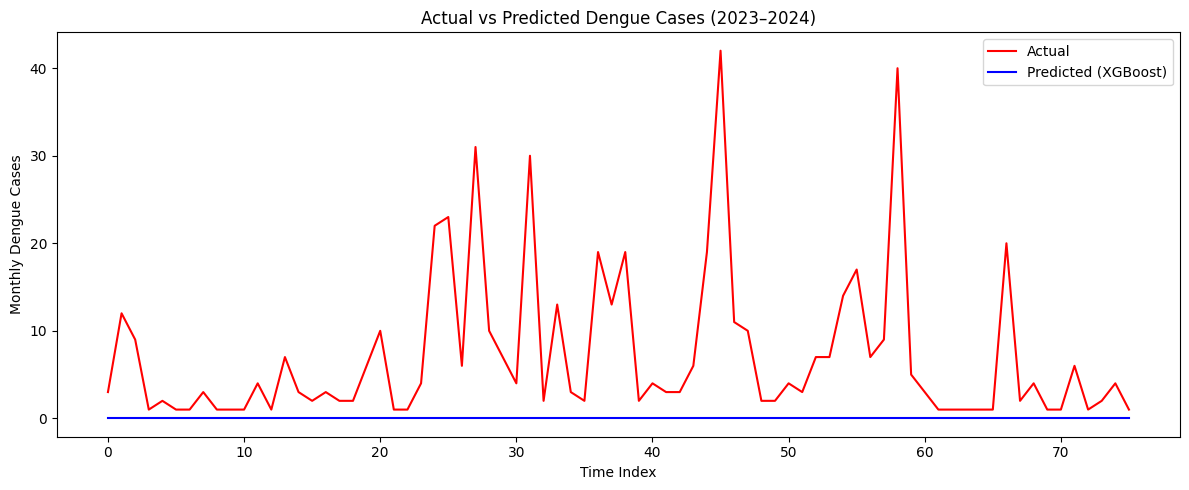

In [75]:
# ======================================
# ✅ Dengue Prediction: Final XGBoost Model
# ======================================
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------- 1. Load & Prepare Data -------------------
df = pd.read_excel("df_final_clean.xlsx")
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# ✅ Aggregate Monthly per District + Subdistrict
agg_df = df.groupby(['อำเภอ', 'ตำบล', 'year', 'month']).agg({
    'cases': 'sum',
    'temp_15d_avg': 'mean',
    'rain_15d_avg': 'mean',
    'humid_15d_avg': 'mean',
    'เพศ': 'count',
    'อายุ(ปี)': 'mean',
    'อาชีพ': lambda x: x.mode()[0] if not x.mode().empty else 'ไม่ทราบ'
}).rename(columns={'เพศ': 'n_cases', 'อายุ(ปี)': 'age_mean'}).reset_index()

# ------------------- 2. Feature Engineering -------------------
agg_df = agg_df.sort_values(['อำเภอ', 'ตำบล', 'year', 'month'])

# Lags
for lag in [1, 3, 6, 12]:
    agg_df[f'cases_lag{lag}'] = agg_df.groupby(['อำเภอ','ตำบล'])['cases'].shift(lag)

# Rolling & diff
agg_df['cases_roll3'] = agg_df.groupby(['อำเภอ','ตำบล'])['cases'].transform(lambda x: x.rolling(3).mean())
agg_df['cases_roll6'] = agg_df.groupby(['อำเภอ','ตำบล'])['cases'].transform(lambda x: x.rolling(6).mean())
agg_df['cases_diff1'] = agg_df.groupby(['อำเภอ','ตำบล'])['cases'].diff(1)

# Climate interactions
agg_df['temp_rain_interaction'] = agg_df['temp_15d_avg'] * agg_df['rain_15d_avg']
agg_df['rain_humid_interaction'] = agg_df['rain_15d_avg'] * agg_df['humid_15d_avg']

# Seasonality sin-cos
agg_df['month_sin'] = np.sin(2 * np.pi * agg_df['month']/12)
agg_df['month_cos'] = np.cos(2 * np.pi * agg_df['month']/12)

# One-hot encoding
agg_df = pd.get_dummies(
    agg_df,
    columns=['อำเภอ', 'ตำบล', 'อาชีพ'],
    drop_first=True
)

# Drop NA
agg_df = agg_df.dropna().reset_index(drop=True)

# ------------------- 3. Features -------------------
target = 'cases'

num_features = [
    'temp_15d_avg', 'rain_15d_avg', 'humid_15d_avg', 'age_mean', 'n_cases',
    'cases_lag1', 'cases_lag3', 'cases_lag6', 'cases_lag12',
    'cases_roll3', 'cases_roll6', 'cases_diff1',
    'temp_rain_interaction', 'rain_humid_interaction',
    'month_sin', 'month_cos'
]

district_features = [c for c in agg_df.columns if c.startswith('อำเภอ_')]
subdistrict_features = [c for c in agg_df.columns if c.startswith('ตำบล_')]
occupation_features = [c for c in agg_df.columns if c.startswith('อาชีพ_')]

features = num_features + district_features + subdistrict_features + occupation_features

X = agg_df[features]
y = agg_df[target]

# ------------------- 4. TimeSeries Cross-Validation -------------------
tscv = TimeSeriesSplit(n_splits=5)
r2_scores = []
rmse_scores = []

print("⏳ TimeSeries Cross-Validation...")
for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.03,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=3,
        gamma=0.1,
        reg_alpha=0.1,
        reg_lambda=1,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2_scores.append(r2_score(y_test, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    print(f"Fold {fold+1} - R²: {r2_scores[-1]:.3f}, RMSE: {rmse_scores[-1]:.2f}")

print("\n📊 TimeSeries Cross-Validation Performance")
print(f"✅ Mean R²  : {np.mean(r2_scores):.3f}")
print(f"✅ Mean RMSE: {np.mean(rmse_scores):.2f}")

# ------------------- 5. Final Holdout (Train < 2023 → Test ≥ 2023) -------------------
train_mask = agg_df["year"] < 2023
X_train, y_train = X[train_mask], y[train_mask]
X_test,  y_test  = X[~train_mask], y[~train_mask]

final_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42
)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

r2_final = r2_score(y_test, y_pred)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred))
mae_final = mean_absolute_error(y_test, y_pred)

print("\n🎯 Final Holdout Evaluation (Train 2017–2022 → Test 2023–2024)")
print(f"✅ R²   : {r2_final:.3f}")
print(f"✅ RMSE : {rmse_final:.2f}")
print(f"✅ MAE  : {mae_final:.2f}")

# ------------------- 6. Plot Actual vs Predicted -------------------
plt.figure(figsize=(12,5))
plt.plot(y_test.values, label="Actual", color='red')
plt.plot(y_pred, label="Predicted (XGBoost)", color='blue')
plt.title("Actual vs Predicted Dengue Cases (2023–2024)")
plt.xlabel("Time Index")
plt.ylabel("Monthly Dengue Cases")
plt.legend()
plt.tight_layout()
plt.show()


ทำ5flod เพื่อเอาค่าที่ดีที่สุด


In [77]:
# ======================================
# ✅ Cross-Validation 5 Folds → เลือก Fold ที่ดีที่สุด (XGBoost)
# ======================================
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# -----------------------------
# 1. Load & Prepare Data
# -----------------------------
df = pd.read_excel("df_final_clean.xlsx")
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Monthly aggregate
agg_df = df.groupby(['อำเภอ','ตำบล','year','month']).agg({
    'cases':'sum',
    'temp_15d_avg':'mean',
    'rain_15d_avg':'mean',
    'humid_15d_avg':'mean',
    'เพศ':'count',
    'อายุ(ปี)':'mean',
    'อาชีพ': lambda x: x.mode()[0] if not x.mode().empty else 'ไม่ทราบ'
}).rename(columns={'เพศ':'n_cases','อายุ(ปี)':'age_mean'}).reset_index()

# Lag features (หลัก ๆ)
agg_df = agg_df.sort_values(['อำเภอ','ตำบล','year','month']).reset_index(drop=True)
for lag in [1,3,6,12]:
    agg_df[f'cases_lag{lag}'] = agg_df.groupby(['อำเภอ','ตำบล'])['cases'].shift(lag)

# Rolling windows
agg_df['cases_roll3'] = agg_df.groupby(['อำเภอ','ตำบล'])['cases'].transform(lambda x: x.shift(1).rolling(3).mean())
agg_df['cases_roll6'] = agg_df.groupby(['อำเภอ','ตำบล'])['cases'].transform(lambda x: x.shift(1).rolling(6).mean())

# One-hot encoding
agg_df = pd.get_dummies(agg_df, columns=['อำเภอ','ตำบล','อาชีพ'], drop_first=True)
agg_df = agg_df.dropna().reset_index(drop=True)

X = agg_df.drop(columns=['cases'])
y = agg_df['cases']

# -----------------------------
# 2. Cross-Validation (5 Folds)
# -----------------------------
tscv = TimeSeriesSplit(n_splits=5)
cv_results = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = XGBRegressor(
        n_estimators=900, learning_rate=0.035, max_depth=6,
        subsample=0.85, colsample_bytree=0.85,
        min_child_weight=3, gamma=0.1, reg_alpha=0.1, reg_lambda=1,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    cv_results.append({
        "Fold": fold,
        "Train Size": len(train_idx),
        "Test Size": len(test_idx),
        "R²": r2_score(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "MAE": mean_absolute_error(y_test, y_pred)
    })

cv_df = pd.DataFrame(cv_results)
print("\n📊 Cross-validation Results (5 folds):")
print(cv_df)

# -----------------------------
# 3. เลือก Fold ที่ดีที่สุด
# -----------------------------
best_fold_idx = cv_df['R²'].idxmax()
best_fold = cv_df.loc[best_fold_idx]
print("\n✅ Suggested Fold for Final Model:", int(best_fold['Fold']))



📊 Cross-validation Results (5 folds):
   Fold  Train Size  Test Size        R²       RMSE       MAE
0     1          16         12 -0.238760  10.915734  6.585901
1     2          28         12 -0.230729   9.417052  6.904764
2     3          40         12  0.342533   8.940499  7.126646
3     4          52         12  0.544156   7.039914  4.036264
4     5          64         12  0.027765   5.097086  3.121682

✅ Suggested Fold for Final Model: 4


ดูความสำคัญเเต่ละตัวแปรต่อตัวแปรyทีละหมวดหมู่

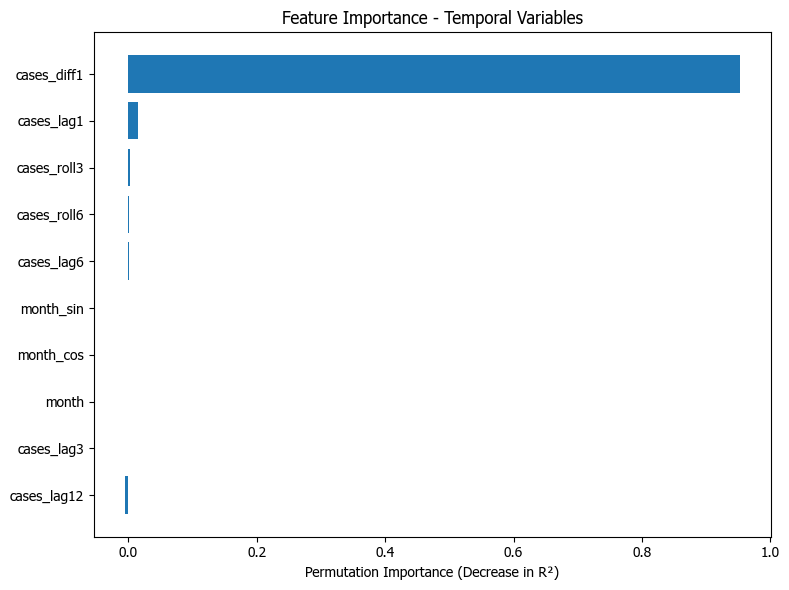

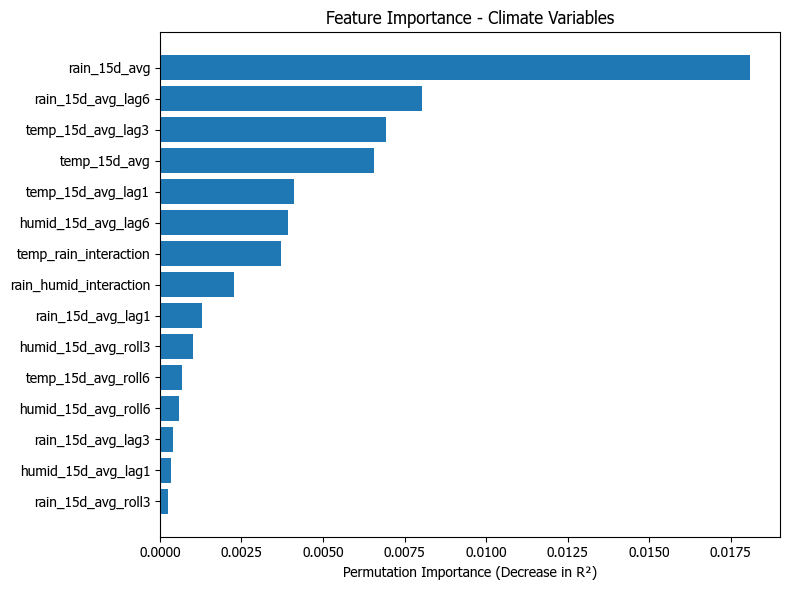

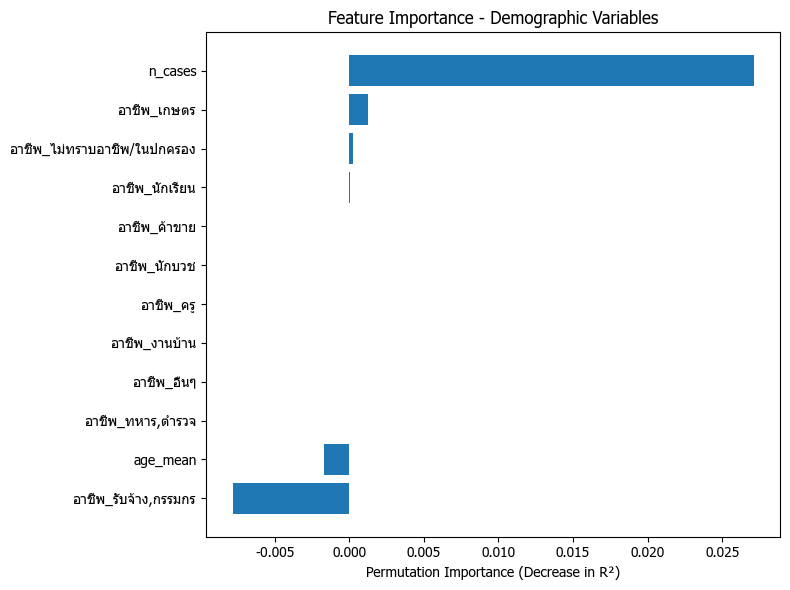

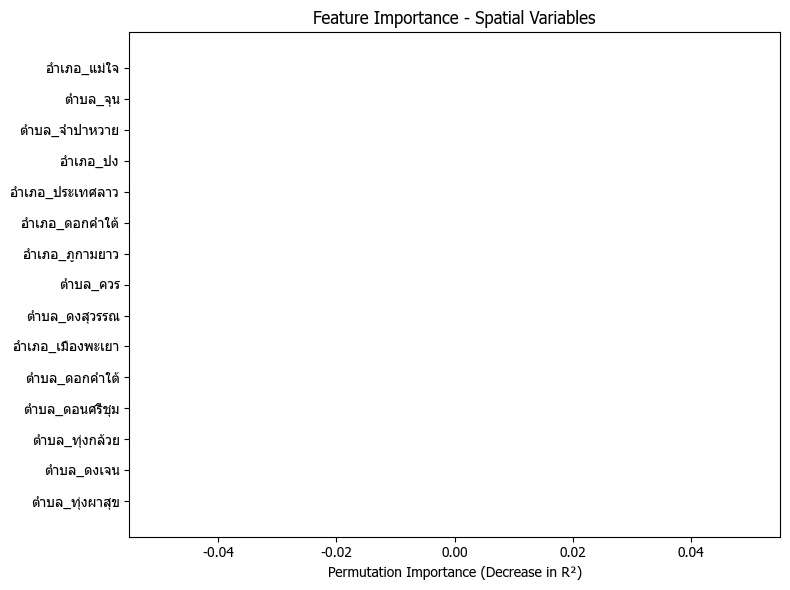

In [90]:
# ======================================
# 📊 Feature Importance by Variable Groups
# ======================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance

# -----------------------------
# 1. Load Data
# -----------------------------
df = pd.read_excel("df_final_clean.xlsx")
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

agg_df = df.groupby(['อำเภอ','ตำบล','year','month']).agg({
    'cases':'sum',
    'temp_15d_avg':'mean',
    'rain_15d_avg':'mean',
    'humid_15d_avg':'mean',
    'เพศ':'count',
    'อายุ(ปี)':'mean',
    'อาชีพ': lambda x: x.mode()[0] if not x.mode().empty else 'ไม่ทราบ'
}).rename(columns={'เพศ':'n_cases','อายุ(ปี)':'age_mean'}).reset_index()

# -----------------------------
# 2. Feature Engineering (lags & rolling)
# -----------------------------
agg_df = agg_df.sort_values(['อำเภอ','ตำบล','year','month']).reset_index(drop=True)
for lag in [1,3,6,12]:
    agg_df[f'cases_lag{lag}'] = agg_df.groupby(['อำเภอ','ตำบล'])['cases'].shift(lag)

agg_df['cases_roll3'] = agg_df.groupby(['อำเภอ','ตำบล'])['cases'].transform(lambda x: x.shift(1).rolling(3).mean())
agg_df['cases_roll6'] = agg_df.groupby(['อำเภอ','ตำบล'])['cases'].transform(lambda x: x.shift(1).rolling(6).mean())
agg_df['cases_diff1'] = agg_df.groupby(['อำเภอ','ตำบล'])['cases'].diff(1)
agg_df['case_growth_ratio'] = (agg_df['cases_lag1'] - agg_df['cases_lag3']) / (agg_df['cases_lag3'] + 1e-6)

for var in ['temp_15d_avg','rain_15d_avg','humid_15d_avg']:
    for lag in [1,3,6]:
        agg_df[f'{var}_lag{lag}'] = agg_df.groupby(['อำเภอ','ตำบล'])[var].shift(lag)
    agg_df[f'{var}_roll3'] = agg_df.groupby(['อำเภอ','ตำบล'])[var].transform(lambda s: s.shift(1).rolling(3).mean())
    agg_df[f'{var}_roll6'] = agg_df.groupby(['อำเภอ','ตำบล'])[var].transform(lambda s: s.shift(1).rolling(6).mean())

agg_df['temp_rain_interaction']       = agg_df['temp_15d_avg'] * agg_df['rain_15d_avg']
agg_df['rain_humid_interaction']      = agg_df['rain_15d_avg'] * agg_df['humid_15d_avg']
agg_df['rain_humid_lag3_interaction'] = agg_df['rain_15d_avg_lag3'] * agg_df['humid_15d_avg_lag3']
agg_df['month_sin'] = np.sin(2*np.pi*agg_df['month']/12)
agg_df['month_cos'] = np.cos(2*np.pi*agg_df['month']/12)

agg_df = pd.get_dummies(agg_df, columns=['อำเภอ','ตำบล','อาชีพ'], drop_first=True)
agg_df = agg_df.dropna().reset_index(drop=True)

# -----------------------------
# 3. Train a model (Fold 4)
# -----------------------------
X = agg_df.drop(columns=['cases'])
y = agg_df['cases']

tscv = TimeSeriesSplit(n_splits=5)
splits = list(tscv.split(X))
train_idx, test_idx = splits[3]  # Fold 4

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

model = XGBRegressor(
    n_estimators=900, learning_rate=0.035, max_depth=6,
    subsample=0.85, colsample_bytree=0.85,
    min_child_weight=3, gamma=0.1, reg_alpha=0.1, reg_lambda=1,
    random_state=42
)
model.fit(X_train, y_train)

# -----------------------------
# 4. Permutation Importance (ทั้งหมด)
# -----------------------------
perm = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
fi_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': perm.importances_mean
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# -----------------------------
# 5. แยกกลุ่มตัวแปร
# -----------------------------
temporal_feats = [f for f in fi_df['Feature'] if f.startswith('cases') or 'month' in f]
climate_feats  = [f for f in fi_df['Feature'] if 'temp' in f or 'rain' in f or 'humid' in f]
demo_feats     = [f for f in fi_df['Feature'] if 'อาชีพ' in f or 'age_mean' in f or 'เพศ' in f or 'n_cases' in f]
spatial_feats  = [f for f in fi_df['Feature'] if f.startswith('อำเภอ_') or f.startswith('ตำบล_')]

# -----------------------------
# 6. ฟังก์ชันวาดกราฟ
# -----------------------------
def plot_feature_group(df, features, title, top_n=15):
    subset = df[df['Feature'].isin(features)].sort_values(by='Importance', ascending=False).head(top_n)
    plt.figure(figsize=(8,6))
    plt.barh(subset['Feature'], subset['Importance'])
    plt.gca().invert_yaxis()
    plt.title(f'Feature Importance - {title}')
    plt.xlabel('Permutation Importance (Decrease in R²)')
    plt.tight_layout()
    plt.show()

# -----------------------------
# 7. วาดกราฟทั้ง 4 กลุ่ม
# -----------------------------
plot_feature_group(fi_df, temporal_feats, 'Temporal Variables')
plot_feature_group(fi_df, climate_feats, 'Climate Variables')
plot_feature_group(fi_df, demo_feats, 'Demographic Variables')
plot_feature_group(fi_df, spatial_feats, 'Spatial Variables')


In [98]:
raw_cols = [
    'cases',
    'temp_15d_avg', 'rain_15d_avg', 'humid_15d_avg',
    'n_cases', 'age_mean',
    'month', 'quarter'
]

# 📌 คำนวณ Correlation matrix เฉพาะตัวแปรดิบ
raw_corr = baseline_df[raw_cols].corr()

# ✅ เรียงลำดับจากมาก→น้อย เฉพาะกับ y = cases
raw_corr_y = raw_corr['cases'].sort_values(ascending=False)
print("📈 Correlation (Raw Variables vs cases):")
print(raw_corr_y)


📈 Correlation (Raw Variables vs cases):
cases            1.000000
n_cases          0.743534
temp_15d_avg     0.106349
rain_15d_avg     0.047043
humid_15d_avg   -0.018239
quarter         -0.033707
age_mean        -0.033916
month           -0.037091
Name: cases, dtype: float64


แยกเอา4

In [ ]:
# ======================================
# ✅ Final XGBoost Model (Fold 4) - Enhanced Features + Plot
# ======================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance
import joblib

# -----------------------------
# 1. Load Data
# -----------------------------
print("📥 Loading dataset...")
df = pd.read_excel("df_final_clean.xlsx")
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Aggregate Monthly per District
agg_df = df.groupby(['อำเภอ', 'ตำบล', 'year', 'month']).agg({
    'cases': 'sum',
    'temp_15d_avg': 'mean',
    'rain_15d_avg': 'mean',
    'humid_15d_avg': 'mean',
    'เพศ': 'count',
    'อายุ(ปี)': 'mean',
    'อาชีพ': lambda x: x.mode()[0] if not x.mode().empty else 'ไม่ทราบ'
}).rename(columns={'เพศ': 'n_cases', 'อายุ(ปี)': 'age_mean'}).reset_index()

# -----------------------------
# 2. Feature Engineering (No Leakage)
# -----------------------------
print("🧠 Feature Engineering...") #เพื่อป้องกัน ข้อมูลรั่ว (data leakage) ก่อนสร้างตัวแปรย้อนเวลา
agg_df = agg_df.sort_values(['อำเภอ', 'ตำบล', 'year', 'month']).reset_index(drop=True)

# Case Lags #Lag Features (ย้อนหลัง 1, 3, 6, 12 เดือน) ให้โมเดลรู้ “ค่าในอดีต”
for lag in [1, 3, 6, 12]:
    agg_df[f'cases_lag{lag}'] = agg_df.groupby(['อำเภอ','ตำบล'])['cases'].shift(lag)

# Case Rolling & Diff Rolling Mean (3, 6 เดือน)เฉลี่ยค่าผู้ป่วยย้อนหลัง เพื่อให้โมเดลเห็นแนวโน้มต่อเนื่อง
agg_df['cases_roll3'] = agg_df.groupby(['อำเภอ','ตำบล'])['cases'].transform(lambda x: x.shift(1).rolling(3).mean())
agg_df['cases_roll6'] = agg_df.groupby(['อำเภอ','ตำบล'])['cases'].transform(lambda x: x.shift(1).rolling(6).mean())
agg_df['cases_diff1'] = agg_df.groupby(['อำเภอ','ตำบล'])['cases'].diff(1)

# Case Growth Ratio
agg_df['case_growth_ratio'] = (agg_df['cases_lag1'] - agg_df['cases_lag3']) / (agg_df['cases_lag3'] + 1e-6)

# Climate lags (1, 3, 6)
climate_vars = ['temp_15d_avg', 'rain_15d_avg', 'humid_15d_avg']
for var in climate_vars:
    for lag in [1, 3, 6]:
        agg_df[f'{var}_lag{lag}'] = agg_df.groupby(['อำเภอ','ตำบล'])[var].shift(lag)
    agg_df[f'{var}_roll3'] = agg_df.groupby(['อำเภอ','ตำบล'])[var].transform(lambda x: x.shift(1).rolling(3).mean())
    agg_df[f'{var}_roll6'] = agg_df.groupby(['อำเภอ','ตำบล'])[var].transform(lambda x: x.shift(1).rolling(6).mean())

# Interaction  Featuresคูณตัวแปรภูมิอากาศเข้าด้วยกัน เพื่อให้โมเดลเห็นผล “ร่วมกัน” เช่น ฝน × อุณหภูมิ
agg_df['temp_rain_interaction'] = agg_df['temp_15d_avg'] * agg_df['rain_15d_avg']
agg_df['rain_humid_interaction'] = agg_df['rain_15d_avg'] * agg_df['humid_15d_avg']
agg_df['rain_humid_lag3_interaction'] = agg_df['rain_15d_avg_lag3'] * agg_df['humid_15d_avg_lag3']

# Seasonality Seasonality Encoding (sin–cos)แทนค่าเดือนเป็นคลื่น sine/cosine เพื่อสะท้อนฤดูกาลแบบต่อเนื่อง (ไม่ตัดตอนที่ ธ.ค.→ม.ค.)
agg_df['month_sin'] = np.sin(2 * np.pi * agg_df['month']/12)
agg_df['month_cos'] = np.cos(2 * np.pi * agg_df['month']/12)

# One-hot encoding สำหรับตัวแปรหมวดหมู่ (categorical) เช่น อำเภอ ตำบล อาชีพเพื่อให้โมเดลอ่านได้โดยไม่จัดอันดับผิด
agg_df = pd.get_dummies(agg_df, columns=['อำเภอ', 'ตำบล', 'อาชีพ'], drop_first=True)
agg_df = agg_df.dropna().reset_index(drop=True) #ลบ Missing หลังสร้างฟีเจอร์

# -----------------------------
# 3. Train/Test Split (Fold 4)
# -----------------------------
target = 'cases'
X = agg_df.drop(columns=[target])
y = agg_df[target]

tscv = TimeSeriesSplit(n_splits=5)
splits = list(tscv.split(X))
train_idx, test_idx = splits[3]

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print(f"📊 Train size: {X_train.shape} | Test size: {X_test.shape}")

# -----------------------------
# 4. Feature Selection (Permutation)
# -----------------------------
print("🧠 Selecting Top 40 features...")
xgb_temp = XGBRegressor(
    n_estimators=900, learning_rate=0.035, max_depth=6,
    subsample=0.85, colsample_bytree=0.85,
    min_child_weight=3, gamma=0.1, reg_alpha=0.1, reg_lambda=1,
    random_state=42
)

split_inner = int(len(X_train)*0.8)
X_tr_in, X_val = X_train.iloc[:split_inner], X_train.iloc[split_inner:]
y_tr_in, y_val = y_train.iloc[:split_inner], y_train.iloc[split_inner:]

xgb_temp.fit(X_tr_in, y_tr_in)
perm = permutation_importance(xgb_temp, X_val, y_val, n_repeats=10, random_state=42)
imp_order = perm.importances_mean.argsort()[::-1]
top_feats = X.columns[imp_order][:40]

print("✅ Top 40 features selected")

# -----------------------------
# 5. Train Final Model
# -----------------------------
print("🚀 Training Final XGB...")
model = XGBRegressor(
    n_estimators=900, learning_rate=0.035, max_depth=6,
    subsample=0.85, colsample_bytree=0.85,
    min_child_weight=3, gamma=0.1, reg_alpha=0.1, reg_lambda=1,
    random_state=42
)
model.fit(X_train[top_feats], y_train)

# -----------------------------
# 6. Evaluate
# -----------------------------
print("📈 Evaluating...")
y_pred = model.predict(X_test[top_feats])
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\n🎯 Enhanced XGBoost Performance (Fold 4)")
print(f"R²   : {r2:.3f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAE  : {mae:.2f}")

# -----------------------------
# 7. Plot Actual vs Predicted + Annotate Peaks
# -----------------------------
X_test_dates = X_test[['year', 'month']].copy()
X_test_dates['date_str'] = pd.to_datetime(
    X_test_dates['year'].astype(str) + '-' + X_test_dates['month'].astype(str) + '-01'
).dt.strftime('%Y-%m')

plt.figure(figsize=(14,6))
plt.plot(X_test_dates['date_str'], y_test.values, label='Actual', color='black', linewidth=2)
plt.plot(X_test_dates['date_str'], y_pred, label='Predicted (XGBoost)', color='blue', linestyle='--', marker='o')

# 🔸 Annotate Peak Points
peak_idx = np.argmax(y_test.values)
plt.annotate(f"Peak\n{y_test.values[peak_idx]:.0f}",
             xy=(peak_idx, y_test.values[peak_idx]),
             xytext=(peak_idx, y_test.values[peak_idx]+5),
             ha='center', arrowprops=dict(facecolor='red', arrowstyle='->'))

plt.xticks(rotation=45, ha='right')
plt.xlabel("Time (Monthly)")
plt.ylabel("Monthly Dengue Cases")
plt.title("Actual vs Predicted Dengue Cases (Fold 4) - Enhanced XGBoost")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# 8. Save Model & Features
# -----------------------------
joblib.dump(xgb_model, "xgb_regressor.pkl")
joblib.dump(list(top_feats), "xgb_features.pkl") 
print("✅ Model and feature list saved for Flask app.")

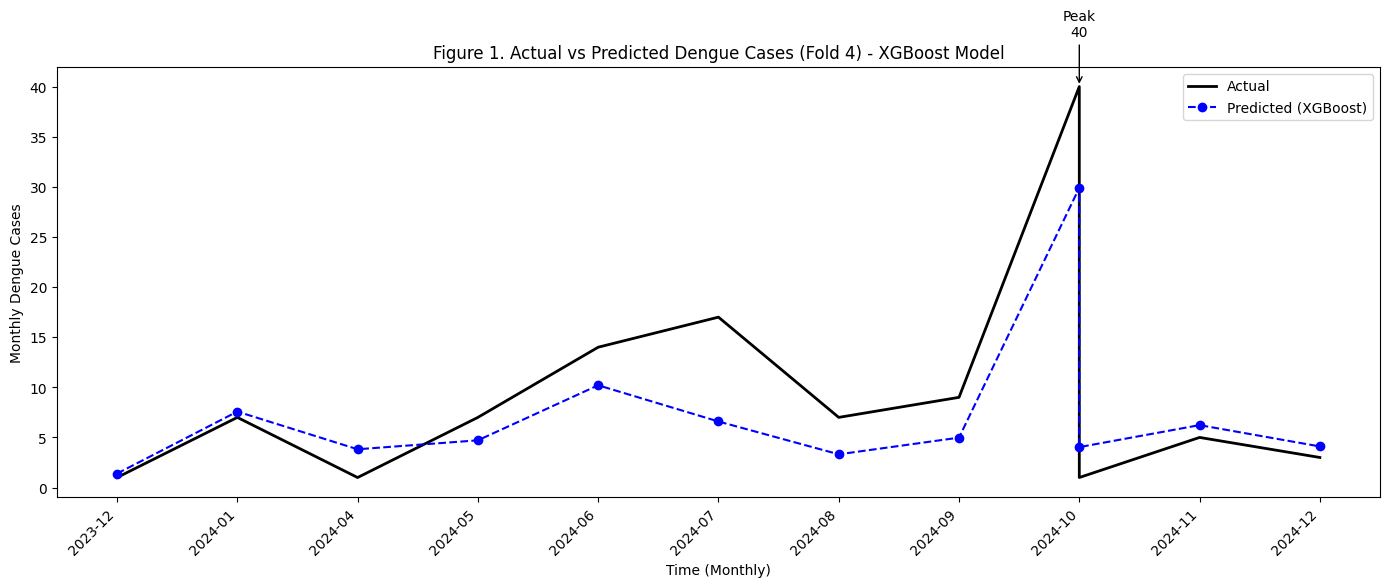

In [4]:
# -----------------------------
# 🧭 FIX: Sort test set by date before plotting
# -----------------------------
plot_df = pd.DataFrame({
    "date_str": X_test_dates['date_str'],
    "Actual": y_test.values,
    "Predicted": y_pred
}).sort_values("date_str")  # ✅ เรียงวันที่

plt.figure(figsize=(14,6))
plt.plot(plot_df['date_str'], plot_df['Actual'], label='Actual', color='black', linewidth=2)
plt.plot(plot_df['date_str'], plot_df['Predicted'], label='Predicted (XGBoost)', 
         color='blue', linestyle='--', marker='o')

# 🔸 Annotate Peak
peak_idx = plot_df['Actual'].idxmax()
peak_date = plot_df.loc[peak_idx, 'date_str']
peak_val = plot_df.loc[peak_idx, 'Actual']

plt.annotate(f"Peak\n{peak_val:.0f}",
             xy=(plot_df.index.get_loc(peak_idx), peak_val),
             xytext=(plot_df.index.get_loc(peak_idx), peak_val + 5),
             ha='center', arrowprops=dict(facecolor='red', arrowstyle='->'))

plt.xticks(rotation=45, ha='right')
plt.xlabel("Time (Monthly)")
plt.ylabel("Monthly Dengue Cases")
plt.title("Figure 1. Actual vs Predicted Dengue Cases (Fold 4) - XGBoost Model")
plt.legend()
plt.tight_layout()
plt.savefig("figure1_actual_vs_predicted_sorted.png", dpi=300, bbox_inches='tight')
plt.show()



📌 Top 20 Important Features (Built-in XGBoost)
               Feature  Importance
           cases_diff1    0.344851
   humid_15d_avg_roll6    0.194271
           cases_roll6    0.101765
     case_growth_ratio    0.058987
               n_cases    0.050221
          rain_15d_avg    0.038986
     temp_15d_avg_lag1    0.036450
    rain_15d_avg_roll3    0.022376
          temp_15d_avg    0.020443
 temp_rain_interaction    0.019101
            cases_lag1    0.015928
  อาชีพ_รับจ้าง,กรรมกร    0.014159
     rain_15d_avg_lag6    0.011012
rain_humid_interaction    0.010222
           cases_lag12    0.009474
     temp_15d_avg_lag6    0.009056
    temp_15d_avg_roll3    0.008340
       ตำบล_ผาช้างน้อย    0.006811
           cases_roll3    0.005468
    humid_15d_avg_lag1    0.004774

📌 Top 20 Important Features (Permutation Importance)
               Feature  PermutationImportance
           cases_diff1               0.912951
               n_cases               0.041559
            cases_lag1   

<Figure size 1000x700 with 0 Axes>

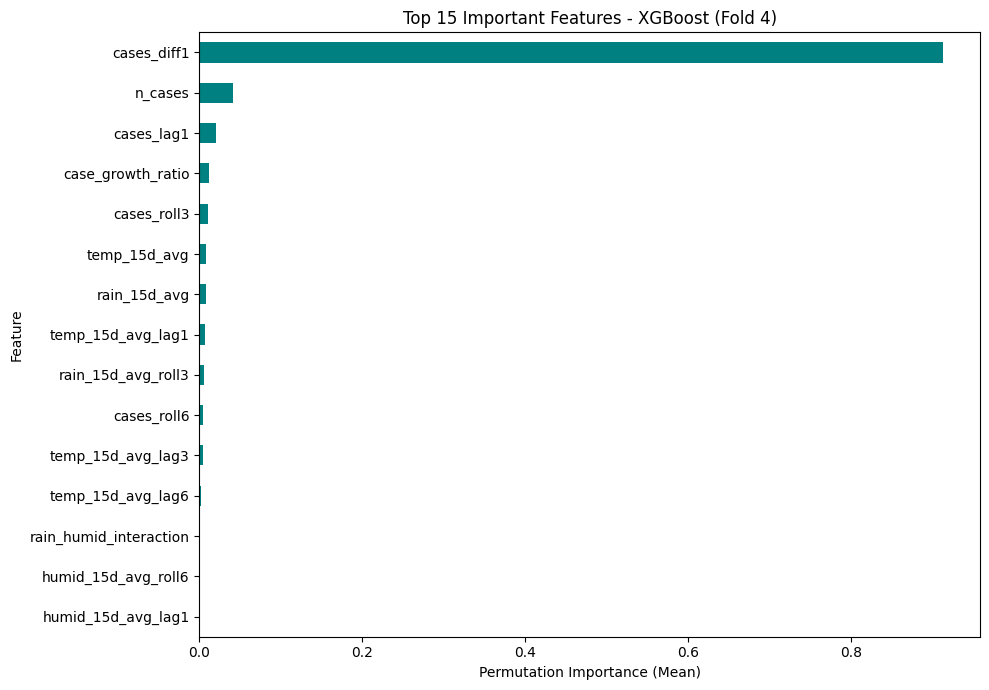

In [81]:
# ======================================
# 📊 Feature Importance (XGBoost - Fold 4)
# ======================================
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# --- ใช้โมเดล XGBoost ที่ train ไปแล้ว ---
xgb_model = fitted_models["XGBoost"]  # จากโค้ดเปรียบเทียบโมเดลเดิม

# --- 1. Built-in Feature Importance ---
xgb_importance = xgb_model.feature_importances_
feat_df = pd.DataFrame({
    "Feature": top_feats,
    "Importance": xgb_importance
}).sort_values(by="Importance", ascending=False)

print("\n📌 Top 20 Important Features (Built-in XGBoost)")
print(feat_df.head(20).to_string(index=False))

# --- 2. Permutation Importance (Reliable Ranking) ---
perm = permutation_importance(
    xgb_model, X_test[top_feats], y_test,
    n_repeats=10, random_state=42, n_jobs=-1
)

perm_df = pd.DataFrame({
    "Feature": top_feats,
    "PermutationImportance": perm.importances_mean
}).sort_values(by="PermutationImportance", ascending=False)

print("\n📌 Top 20 Important Features (Permutation Importance)")
print(perm_df.head(20).to_string(index=False))

# --- Plot Top 15 ---
plt.figure(figsize=(10, 7))
perm_df.head(15).plot(
    x="Feature", y="PermutationImportance", kind="barh",
    legend=False, figsize=(10, 7), color="teal"
)
plt.gca().invert_yaxis()
plt.xlabel("Permutation Importance (Mean)")
plt.ylabel("Feature")
plt.title("Top 15 Important Features - XGBoost (Fold 4)")
plt.tight_layout()
plt.show()


ทำอันนี้ล่าสุด

✅ Fold 4 | Train: (52, 119), Test: (12, 119)
✅ Selected top 40 features

📈 Regression Metrics (Fold 4)
          Model        R²      RMSE       MAE
0       XGBoost  0.785318  4.831219  3.621198
1  RandomForest  0.690354  5.802186  3.947292
2      Stacking  0.782330  4.864724  3.465218

🌿 Outbreak Detection Metrics (Fold 4, P80)
          Model  Accuracy  Precision    Recall   F1       AUC
0       XGBoost  0.833333        1.0  0.333333  0.5  0.962963
1  RandomForest  0.833333        1.0  0.333333  0.5  0.962963
2      Stacking  0.833333        1.0  0.333333  0.5  0.962963


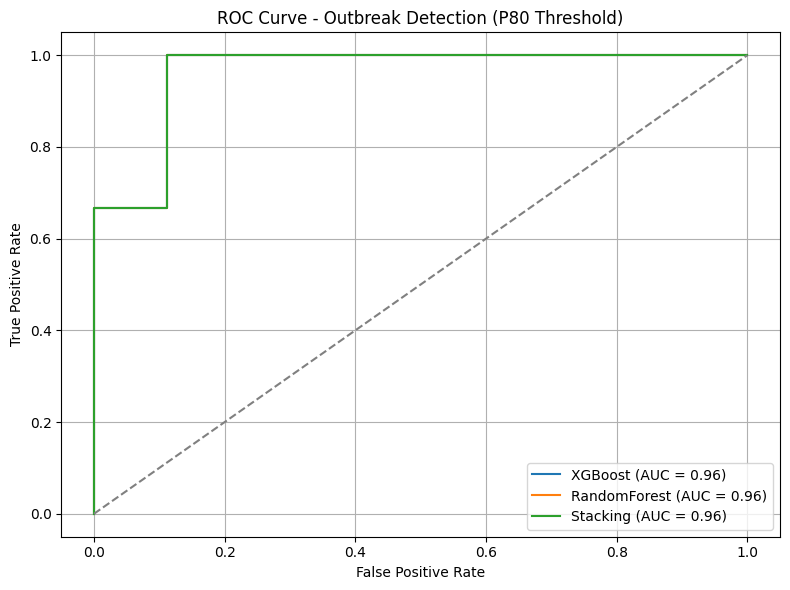


📊 Final Model Performance Summary (Fold 4)
       Model       R²     RMSE      MAE  Accuracy  Precision   Recall  F1      AUC
     XGBoost 0.785318 4.831219 3.621198  0.833333        1.0 0.333333 0.5 0.962963
    Stacking 0.782330 4.864724 3.465218  0.833333        1.0 0.333333 0.5 0.962963
RandomForest 0.690354 5.802186 3.947292  0.833333        1.0 0.333333 0.5 0.962963
💾 Results saved to model_comparison_fold4.csv


In [80]:
# ======================================
# 🧠 Fold 4 | XGBoost, RF, Stacking + Outbreak Detection (P80)
# ======================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
)
from sklearn.inspection import permutation_importance

# -----------------------------
# 1. Load & Aggregate Data
# -----------------------------
df = pd.read_excel("df_final_clean.xlsx")
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

agg_df = df.groupby(['อำเภอ', 'ตำบล', 'year', 'month']).agg({
    'cases': 'sum',
    'temp_15d_avg': 'mean',
    'rain_15d_avg': 'mean',
    'humid_15d_avg': 'mean',
    'เพศ': 'count',
    'อายุ(ปี)': 'mean',
    'อาชีพ': lambda x: x.mode()[0] if not x.mode().empty else 'ไม่ทราบ'
}).rename(columns={'เพศ': 'n_cases', 'อายุ(ปี)': 'age_mean'}).reset_index()

# -----------------------------
# 2. Feature Engineering
# -----------------------------
agg_df = agg_df.sort_values(['อำเภอ','ตำบล','year','month']).reset_index(drop=True)

# Case lag & rolling
for lag in [1,3,6,12]:
    agg_df[f'cases_lag{lag}'] = agg_df.groupby(['อำเภอ','ตำบล'])['cases'].shift(lag)
agg_df['cases_roll3'] = agg_df.groupby(['อำเภอ','ตำบล'])['cases'].transform(lambda x: x.shift(1).rolling(3).mean())
agg_df['cases_roll6'] = agg_df.groupby(['อำเภอ','ตำบล'])['cases'].transform(lambda x: x.shift(1).rolling(6).mean())
agg_df['cases_diff1'] = agg_df.groupby(['อำเภอ','ตำบล'])['cases'].diff(1)
agg_df['case_growth_ratio'] = (agg_df['cases_lag1'] - agg_df['cases_lag3']) / (agg_df['cases_lag3'] + 1e-6)

# Climate lag/rolling
climate_vars = ['temp_15d_avg', 'rain_15d_avg', 'humid_15d_avg']
for var in climate_vars:
    for lag in [1,3,6]:
        agg_df[f'{var}_lag{lag}'] = agg_df.groupby(['อำเภอ','ตำบล'])[var].shift(lag)
    agg_df[f'{var}_roll3'] = agg_df.groupby(['อำเภอ','ตำบล'])[var].transform(lambda x: x.shift(1).rolling(3).mean())
    agg_df[f'{var}_roll6'] = agg_df.groupby(['อำเภอ','ตำบล'])[var].transform(lambda x: x.shift(1).rolling(6).mean())

# Interaction + Seasonality
agg_df['temp_rain_interaction'] = agg_df['temp_15d_avg'] * agg_df['rain_15d_avg']
agg_df['rain_humid_interaction'] = agg_df['rain_15d_avg'] * agg_df['humid_15d_avg']
agg_df['rain_humid_lag3_interaction'] = agg_df['rain_15d_avg_lag3'] * agg_df['humid_15d_avg_lag3']
agg_df['month_sin'] = np.sin(2*np.pi*agg_df['month']/12)
agg_df['month_cos'] = np.cos(2*np.pi*agg_df['month']/12)

# One-hot encoding
agg_df = pd.get_dummies(agg_df, columns=['อำเภอ','ตำบล','อาชีพ'], drop_first=True)
agg_df = agg_df.dropna().reset_index(drop=True)

# -----------------------------
# 3. Train/Test Split (Fold 4)
# -----------------------------
target = 'cases'
X = agg_df.drop(columns=[target])
y = agg_df[target]

tscv = TimeSeriesSplit(n_splits=5)
splits = list(tscv.split(X))
train_idx, test_idx = splits[3]  # Fold 4

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print(f"✅ Fold 4 | Train: {X_train.shape}, Test: {X_test.shape}")

# -----------------------------
# 4. Feature Selection (Permutation)
# -----------------------------
xgb_temp = XGBRegressor(
    n_estimators=900, learning_rate=0.035, max_depth=6,
    subsample=0.85, colsample_bytree=0.85,
    min_child_weight=3, gamma=0.1, reg_alpha=0.1, reg_lambda=1,
    random_state=42
)
split_inner = int(len(X_train)*0.8)
X_tr_in, X_val = X_train.iloc[:split_inner], X_train.iloc[split_inner:]
y_tr_in, y_val = y_train.iloc[:split_inner], y_train.iloc[split_inner:]

xgb_temp.fit(X_tr_in, y_tr_in)
perm = permutation_importance(xgb_temp, X_val, y_val, n_repeats=10, random_state=42)
imp_order = perm.importances_mean.argsort()[::-1]
top_feats = X.columns[imp_order][:40]
print(f"✅ Selected top {len(top_feats)} features")

# -----------------------------
# 5. Train Models (Regression)
# -----------------------------
models = {
    "XGBoost": XGBRegressor(
        n_estimators=900, learning_rate=0.035, max_depth=6,
        subsample=0.85, colsample_bytree=0.85,
        min_child_weight=3, gamma=0.1, reg_alpha=0.1, reg_lambda=1,
        random_state=42
    ),
    "RandomForest": RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1),
    "Stacking": StackingRegressor(
        estimators=[
            ("xgb", XGBRegressor(
                n_estimators=900, learning_rate=0.035, max_depth=6,
                subsample=0.85, colsample_bytree=0.85,
                min_child_weight=3, gamma=0.1, reg_alpha=0.1, reg_lambda=1,
                random_state=42
            )),
            ("rf", RandomForestRegressor(n_estimators=400, random_state=42))
        ],
        final_estimator=Ridge(alpha=1.0),
        n_jobs=-1
    )
}

reg_results = []
fitted_models = {}
for name, model in models.items():
    model.fit(X_train[top_feats], y_train)
    y_pred = model.predict(X_test[top_feats])
    fitted_models[name] = model
    reg_results.append({
        "Model": name,
        "R²": r2_score(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "MAE": mean_absolute_error(y_test, y_pred)
    })

reg_df = pd.DataFrame(reg_results)
print("\n📈 Regression Metrics (Fold 4)")
print(reg_df)

# -----------------------------
# -----------------------------
# 6. 🦠 Outbreak Detection (P80)
# -----------------------------
from sklearn.metrics import f1_score

p80_threshold = np.percentile(y_train, 80)
y_true_cls = (y_test > p80_threshold).astype(int)

clf_results = []

plt.figure(figsize=(8, 6))
for name, model in fitted_models.items():
    y_pred_reg = model.predict(X_test[top_feats])
    y_pred_cls = (y_pred_reg >= p80_threshold).astype(int)

    acc = accuracy_score(y_true_cls, y_pred_cls)
    prec = precision_score(y_true_cls, y_pred_cls, zero_division=0)
    rec = recall_score(y_true_cls, y_pred_cls, zero_division=0)
    f1 = f1_score(y_true_cls, y_pred_cls, zero_division=0)
    auc = roc_auc_score(y_true_cls, y_pred_reg)

    clf_results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "AUC": auc
    })

    fpr, tpr, _ = roc_curve(y_true_cls, y_pred_reg)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

clf_df = pd.DataFrame(clf_results)
print("\n🌿 Outbreak Detection Metrics (Fold 4, P80)")
print(clf_df)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Outbreak Detection (P80 Threshold)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# 7. 📊 รวม Regression + Classification Metrics
# -----------------------------
final_results = pd.merge(reg_df, clf_df, on="Model", how="left")

# เรียงตาม RMSE จากน้อยไปมาก
final_results = final_results.sort_values(by="RMSE")

# เลือกคอลัมน์สำคัญให้อ่านง่าย
final_results = final_results[
    ['Model', 'R²', 'RMSE', 'MAE', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
]

print("\n📊 Final Model Performance Summary (Fold 4)")
print(final_results.to_string(index=False))

# -----------------------------
# 8. ✅ Export เป็น CSV (optional)
# -----------------------------
final_results.to_csv("model_comparison_fold4.csv", index=False)
print("💾 Results saved to model_comparison_fold4.csv")


✅ Fold 4 | Train: (52, 119), Test: (12, 119)
✅ Selected top 40 features

📈 Regression Metrics (Fold 4)
          Model        R²      RMSE       MAE
0       XGBoost  0.785318  4.831219  3.621198
1  RandomForest  0.690354  5.802186  3.947292
2      Stacking  0.782330  4.864724  3.465218

🧾 Summary for Paper (Fold 4)
          Model        R²      RMSE       MAE  Accuracy (>=1 case)
0       XGBoost  0.785318  4.831219  3.621198             1.000000
1  RandomForest  0.690354  5.802186  3.947292             1.000000
2      Stacking  0.782330  4.864724  3.465218             0.916667

🌿 Outbreak Detection Metrics (Fold 4 - Multi Threshold)
          Model Threshold  Accuracy  Precision    Recall       AUC
0       XGBoost       P60  0.666667   0.800000  0.571429  0.828571
1  RandomForest       P60  0.750000   0.833333  0.714286  0.885714
2      Stacking       P60  0.750000   1.000000  0.571429  0.828571
3       XGBoost       P70  0.833333   1.000000  0.500000  0.906250
4  RandomForest       P

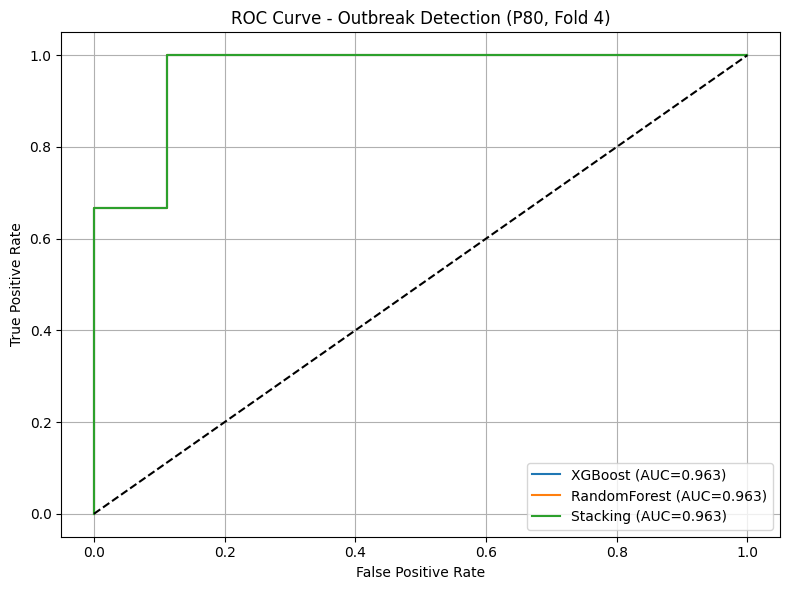

In [ ]:
# ======================================
# 🧠 Fold 4 | XGBoost, RF, Stacking + Multi Threshold + Fixed Accuracy
# ======================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
)
from sklearn.inspection import permutation_importance

# -----------------------------
# 1) Load & Aggregate
# -----------------------------
df = pd.read_excel("df_final_clean.xlsx")
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

agg_df = df.groupby(['อำเภอ','ตำบล','year','month']).agg({
    'cases':'sum',
    'temp_15d_avg':'mean','rain_15d_avg':'mean','humid_15d_avg':'mean',
    'เพศ':'count','อายุ(ปี)':'mean',
    'อาชีพ':lambda x: x.mode()[0] if not x.mode().empty else 'ไม่ทราบ'
}).rename(columns={'เพศ':'n_cases','อายุ(ปี)':'age_mean'}).reset_index()

# -----------------------------
# 2) Feature Engineering (no leakage)
# -----------------------------
agg_df = agg_df.sort_values(['อำเภอ','ตำบล','year','month']).reset_index(drop=True)

# case lags/rolling
for lag in [1,3,6,12]:
    agg_df[f'cases_lag{lag}'] = agg_df.groupby(['อำเภอ','ตำบล'])['cases'].shift(lag)
agg_df['cases_roll3'] = agg_df.groupby(['อำเภอ','ตำบล'])['cases'].transform(lambda x: x.shift(1).rolling(3).mean())
agg_df['cases_roll6'] = agg_df.groupby(['อำเภอ','ตำบล'])['cases'].transform(lambda x: x.shift(1).rolling(6).mean())
agg_df['cases_diff1'] = agg_df.groupby(['อำเภอ','ตำบล'])['cases'].diff(1)
agg_df['case_growth_ratio'] = (agg_df['cases_lag1'] - agg_df['cases_lag3']) / (agg_df['cases_lag3'] + 1e-6)

# climate lags/rolling
climate_vars = ['temp_15d_avg','rain_15d_avg','humid_15d_avg']
for var in climate_vars:
    for lag in [1,3,6]:
        agg_df[f'{var}_lag{lag}'] = agg_df.groupby(['อำเภอ','ตำบล'])[var].shift(lag)
    agg_df[f'{var}_roll3'] = agg_df.groupby(['อำเภอ','ตำบล'])[var].transform(lambda x: x.shift(1).rolling(3).mean())
    agg_df[f'{var}_roll6'] = agg_df.groupby(['อำเภอ','ตำบล'])[var].transform(lambda x: x.shift(1).rolling(6).mean())

# interaction + seasonality
agg_df['temp_rain_interaction'] = agg_df['temp_15d_avg']*agg_df['rain_15d_avg']
agg_df['rain_humid_interaction'] = agg_df['rain_15d_avg']*agg_df['humid_15d_avg']
agg_df['rain_humid_lag3_interaction'] = agg_df['rain_15d_avg_lag3']*agg_df['humid_15d_avg_lag3']
agg_df['month_sin'] = np.sin(2*np.pi*agg_df['month']/12)
agg_df['month_cos'] = np.cos(2*np.pi*agg_df['month']/12)

# one-hot
agg_df = pd.get_dummies(agg_df, columns=['อำเภอ','ตำบล','อาชีพ'], drop_first=True)
agg_df = agg_df.dropna().reset_index(drop=True)

# -----------------------------
# 3) Train/Test Split (Fold 4)
# -----------------------------
target = 'cases'
X = agg_df.drop(columns=[target])
y = agg_df[target]

tscv = TimeSeriesSplit(n_splits=5)
splits = list(tscv.split(X))
train_idx, test_idx = splits[3]  # fold 4
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
print(f"✅ Fold 4 | Train: {X_train.shape}, Test: {X_test.shape}")

# -----------------------------
# 4) Permutation-based feature selection
# -----------------------------
xgb_temp = XGBRegressor(
    n_estimators=900, learning_rate=0.035, max_depth=6,
    subsample=0.85, colsample_bytree=0.85,
    min_child_weight=3, gamma=0.1, reg_alpha=0.1, reg_lambda=1,
    random_state=42
)
split_inner = int(len(X_train)*0.8)
X_tr_in, X_val = X_train.iloc[:split_inner], X_train.iloc[split_inner:]
y_tr_in, y_val = y_train.iloc[:split_inner], y_train.iloc[split_inner:]
xgb_temp.fit(X_tr_in, y_tr_in)
perm = permutation_importance(xgb_temp, X_val, y_val, n_repeats=10, random_state=42)
imp_order = perm.importances_mean.argsort()[::-1]
top_feats = X.columns[imp_order][:40]
print(f"✅ Selected top {len(top_feats)} features")

# -----------------------------
# 5) Train models (regression)
# -----------------------------
models = {
    "XGBoost": XGBRegressor(
        n_estimators=900, learning_rate=0.035, max_depth=6,
        subsample=0.85, colsample_bytree=0.85,
        min_child_weight=3, gamma=0.1, reg_alpha=0.1, reg_lambda=1,
        random_state=42
    ),
    "RandomForest": RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1),
    "Stacking": StackingRegressor(
        estimators=[
            ("xgb", XGBRegressor(
                n_estimators=900, learning_rate=0.035, max_depth=6,
                subsample=0.85, colsample_bytree=0.85,
                min_child_weight=3, gamma=0.1, reg_alpha=0.1, reg_lambda=1,
                random_state=42
            )),
            ("rf", RandomForestRegressor(n_estimators=400, random_state=42))
        ],
        final_estimator=Ridge(alpha=1.0),
        n_jobs=-1
    ),
}

reg_rows = []
fitted_models, preds_test = {}, {}

for name, mdl in models.items():
    mdl.fit(X_train[top_feats], y_train)
    y_pred = mdl.predict(X_test[top_feats])
    preds_test[name] = y_pred
    fitted_models[name] = mdl
    reg_rows.append({
        "Model": name,
        "R²": r2_score(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "MAE": mean_absolute_error(y_test, y_pred),
    })

reg_df = pd.DataFrame(reg_rows)
print("\n📈 Regression Metrics (Fold 4)")
print(reg_df)

# -----------------------------
# 6) ✅ Fixed-threshold Accuracy (ไม่ใช้ outbreak percentile)
#    - outbreak = 1 เมื่อ cases >= 1 (ตั้งค่าได้ตามบริบท)
# -----------------------------
fixed_threshold = 1
fixed_rows = []
for name in models.keys():
    y_pred_reg = preds_test[name]
    y_true_cls_fixed = (y_test.values >= fixed_threshold).astype(int)
    y_pred_cls_fixed = (y_pred_reg >= fixed_threshold).astype(int)
    acc_fixed = accuracy_score(y_true_cls_fixed, y_pred_cls_fixed)
    fixed_rows.append({"Model": name, "Accuracy (>=1 case)": acc_fixed})

acc_fixed_df = pd.DataFrame(fixed_rows)

# 🔗 Merge เพื่อทำ "ตารางสรุปสำหรับงานเขียน" = RMSE / MAE / R² / Accuracy
summary_df = reg_df.merge(acc_fixed_df, on="Model")
print("\n🧾 Summary for Paper (Fold 4)")
print(summary_df)

# -----------------------------
# 7) (Optional) Multi-threshold outbreak metrics + ROC@P80
# -----------------------------
thresholds = [60, 70, 80]
clf_results_multi = []
for p in thresholds:
    p_threshold = np.percentile(y_train, p)
    y_true_cls = (y_test > p_threshold).astype(int)
    for name in models.keys():
        y_pred_reg = preds_test[name]
        y_pred_cls = (y_pred_reg >= p_threshold).astype(int)
        clf_results_multi.append({
            "Model": name,
            "Threshold": f"P{p}",
            "Accuracy": accuracy_score(y_true_cls, y_pred_cls),
            "Precision": precision_score(y_true_cls, y_pred_cls, zero_division=0),
            "Recall": recall_score(y_true_cls, y_pred_cls, zero_division=0),
            "AUC": roc_auc_score(y_true_cls, y_pred_reg),
        })
clf_multi_df = pd.DataFrame(clf_results_multi)
print("\n🌿 Outbreak Detection Metrics (Fold 4 - Multi Threshold)")
print(clf_multi_df)

# ROC (P80)
plt.figure(figsize=(8,6))
p80 = np.percentile(y_train, 80)
y_true_p80 = (y_test > p80).astype(int)
for name in models.keys():
    y_pred_reg = preds_test[name]
    fpr, tpr, _ = roc_curve(y_true_p80, y_pred_reg)
    auc = roc_auc_score(y_true_p80, y_pred_reg)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Outbreak Detection (P80, Fold 4)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


สถิติ เทียบ

In [ ]:
pip install mlxtend


   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   --------------- ------------------------ 0.5/1.4 MB 4.2 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 6.9 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


เทียบทั้งสถิติเเละxg boost

In [71]:
====================================== # ✅ XGBoost Model with Enhanced Features (No Leakage) # ====================================== import pandas as pd import numpy as np from xgboost import XGBRegressor from sklearn.model_selection import TimeSeriesSplit from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error from sklearn.inspection import permutation_importance import joblib # ----------------------------- # 1. Load Data # ----------------------------- df = pd.read_excel("df_final_clean.xlsx") df['date'] = pd.to_datetime(df['date']) df['year'] = df['date'].dt.year df['month'] = df['date'].dt.month agg_df = df.groupby(['อำเภอ', 'ตำบล', 'year', 'month']).agg({ 'cases': 'sum', 'temp_15d_avg': 'mean', 'rain_15d_avg': 'mean', 'humid_15d_avg': 'mean', 'เพศ': 'count', 'อายุ(ปี)': 'mean', 'อาชีพ': lambda x: x.mode()[0] if not x.mode().empty else 'ไม่ทราบ' }).rename(columns={'เพศ': 'n_cases', 'อายุ(ปี)': 'age_mean'}).reset_index() # ----------------------------- # 2. Feature Engineering (No Leakage) # ----------------------------- agg_df = agg_df.sort_values(['อำเภอ', 'ตำบล', 'year', 'month']).reset_index(drop=True) # Lags (cases) for lag in [1, 3, 6, 12]: agg_df[f'cases_lag{lag}'] = agg_df.groupby(['อำเภอ','ตำบล'])['cases'].shift(lag) # Rolling windows (cases) agg_df['cases_roll3'] = agg_df.groupby(['อำเภอ','ตำบล'])['cases'].transform(lambda x: x.shift(1).rolling(3).mean()) agg_df['cases_roll6'] = agg_df.groupby(['อำเภอ','ตำบล'])['cases'].transform(lambda x: x.shift(1).rolling(6).mean()) agg_df['cases_diff1'] = agg_df.groupby(['อำเภอ','ตำบล'])['cases'].diff(1) # Growth ratio agg_df['case_growth_ratio'] = (agg_df['cases_lag1'] - agg_df['cases_lag3']) / (agg_df['cases_lag3'] + 1e-6) # Climate lags (1, 3, 6) climate_vars = ['temp_15d_avg', 'rain_15d_avg', 'humid_15d_avg'] for var in climate_vars: for lag in [1, 3, 6]: agg_df[f'{var}_lag{lag}'] = agg_df.groupby(['อำเภอ','ตำบล'])[var].shift(lag) # Rolling mean agg_df[f'{var}_roll3'] = agg_df.groupby(['อำเภอ','ตำบล'])[var].transform(lambda x: x.shift(1).rolling(3).mean()) agg_df[f'{var}_roll6'] = agg_df.groupby(['อำเภอ','ตำบล'])[var].transform(lambda x: x.shift(1).rolling(6).mean()) # Interaction terms (including lags) agg_df['temp_rain_interaction'] = agg_df['temp_15d_avg'] * agg_df['rain_15d_avg'] agg_df['rain_humid_interaction'] = agg_df['rain_15d_avg'] * agg_df['humid_15d_avg'] agg_df['rain_humid_lag3_interaction'] = agg_df['rain_15d_avg_lag3'] * agg_df['humid_15d_avg_lag3'] # Seasonality agg_df['month_sin'] = np.sin(2 * np.pi * agg_df['month']/12) agg_df['month_cos'] = np.cos(2 * np.pi * agg_df['month']/12) # One-hot encoding agg_df = pd.get_dummies(agg_df, columns=['อำเภอ', 'ตำบล', 'อาชีพ'], drop_first=True) agg_df = agg_df.dropna().reset_index(drop=True) # ----------------------------- # 3. Train/Test Split (Fold 4) # ----------------------------- target = 'cases' X = agg_df.drop(columns=[target]) y = agg_df[target] tscv = TimeSeriesSplit(n_splits=5) splits = list(tscv.split(X)) train_idx, test_idx = splits[3] X_train, X_test = X.iloc[train_idx], X.iloc[test_idx] y_train, y_test = y.iloc[train_idx], y.iloc[test_idx] # ----------------------------- # 4. Feature Selection # ----------------------------- xgb_temp = XGBRegressor( n_estimators=900, learning_rate=0.035, max_depth=6, subsample=0.85, colsample_bytree=0.85, min_child_weight=3, gamma=0.1, reg_alpha=0.1, reg_lambda=1, random_state=42 ) split_inner = int(len(X_train)*0.8) X_tr_in, X_val = X_train.iloc[:split_inner], X_train.iloc[split_inner:] y_tr_in, y_val = y_train.iloc[:split_inner], y_train.iloc[split_inner:] xgb_temp.fit(X_tr_in, y_tr_in) perm = permutation_importance(xgb_temp, X_val, y_val, n_repeats=10, random_state=42) imp_order = perm.importances_mean.argsort()[::-1] top_feats = X.columns[imp_order][:40] # เพิ่มเป็น 40 features # ----------------------------- # 5. Train Final XGB # ----------------------------- model = XGBRegressor( n_estimators=900, learning_rate=0.035, max_depth=6, subsample=0.85, colsample_bytree=0.85, min_child_weight=3, gamma=0.1, reg_alpha=0.1, reg_lambda=1, random_state=42 ) model.fit(X_train[top_feats], y_train) # ----------------------------- # 6. Evaluate # ----------------------------- y_pred = model.predict(X_test[top_feats]) r2 = r2_score(y_test, y_pred) rmse = np.sqrt(mean_squared_error(y_test, y_pred)) mae = mean_absolute_error(y_test, y_pred) print("\n🎯 Enhanced XGBoost Performance (Fold 4)") print(f"R² : {r2:.3f}") print(f"RMSE : {rmse:.2f}") print(f"MAE : {mae:.2f}")

SyntaxError: invalid syntax (3365740961.py, line 1)


📈 Negative Binomial Regression Metrics
                       Model  McFadden R²      RMSE       MAE  Overdispersion
0  Negative Binomial (Stat.)     0.382742  5.181672  4.171565         1.03428

🦠 Outbreak Detection (P80 Threshold)
                       Model  Accuracy  Precision    Recall  AUC
0  Negative Binomial (Stat.)  0.833333        1.0  0.333333  1.0


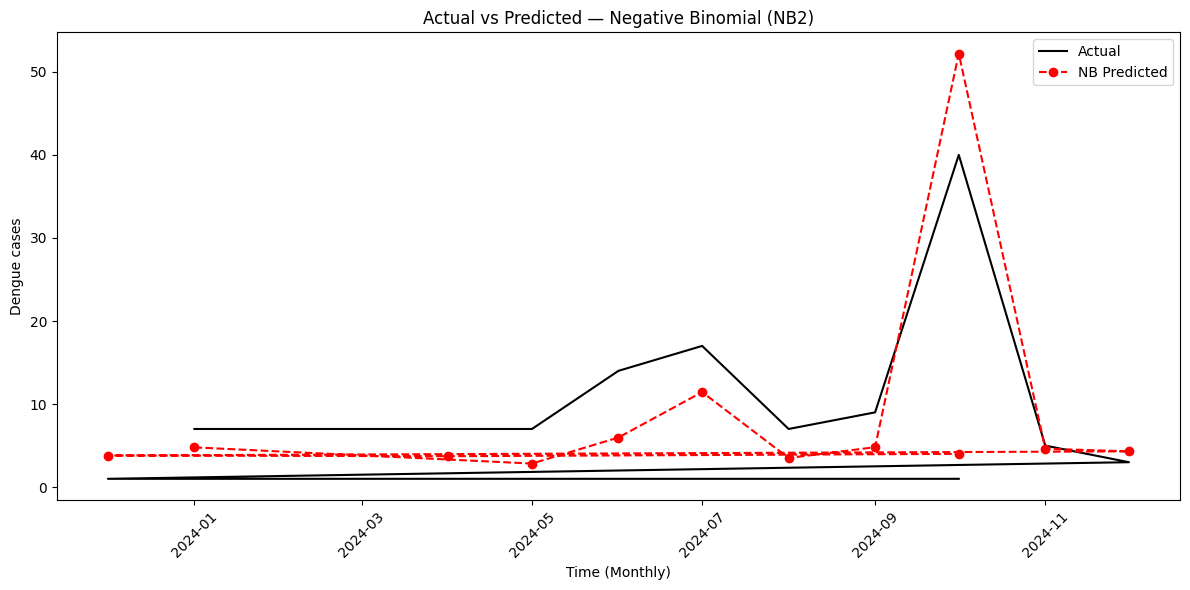

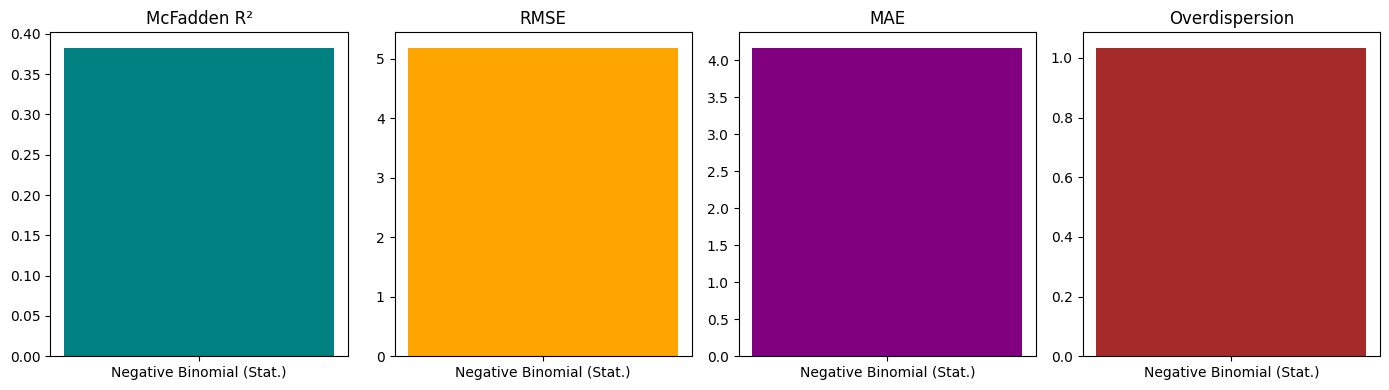

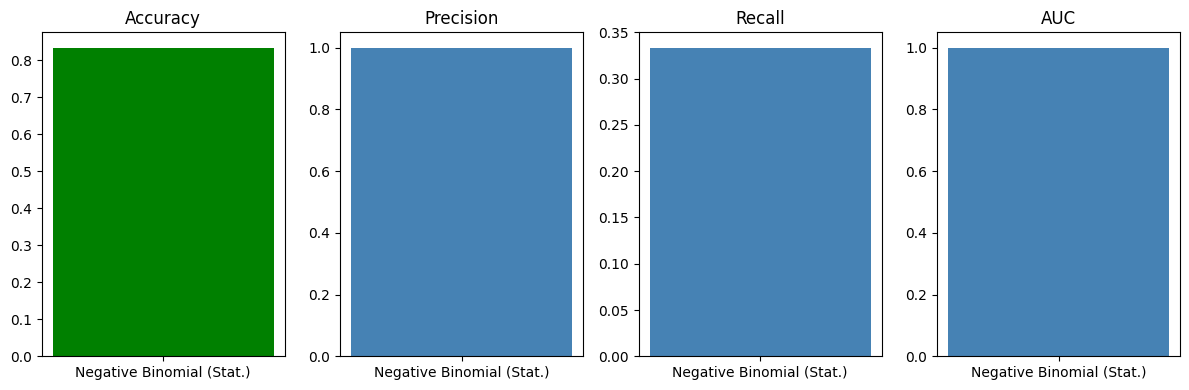

In [ ]:
# ======================================
# 📊 Negative Binomial Regression (Stat only)
# ✅ Fold 4 (same split as ML) + P80 outbreak + Paper-ready plots
# ======================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

from sklearn.metrics import (
    mean_squared_error, mean_absolute_error,
    accuracy_score, precision_score, recall_score, roc_auc_score
)

import statsmodels.api as sm
from statsmodels.discrete.discrete_model import NegativeBinomial as NB2

# -----------------------------
# 0) Config
# -----------------------------
TOP_K_FEATURES = 30   # จำนวนฟีเจอร์สูงสุดที่จะใช้กับ NB เพื่อลดความซับซ้อน
SEED = 42

# -----------------------------
# 1) Load & aggregate
# -----------------------------
df = pd.read_excel("df_final_clean.xlsx")
df['date']  = pd.to_datetime(df['date'])
df['year']  = df['date'].dt.year
df['month'] = df['date'].dt.month

agg_df = df.groupby(['อำเภอ','ตำบล','year','month']).agg({
    'cases'        : 'sum',
    'temp_15d_avg' : 'mean',
    'rain_15d_avg' : 'mean',
    'humid_15d_avg': 'mean',
    'เพศ'          : 'count',
    'อายุ(ปี)'      : 'mean',
    'อาชีพ'        : (lambda x: x.mode()[0] if not x.mode().empty else 'ไม่ทราบ')
}).rename(columns={'เพศ':'n_cases','อายุ(ปี)':'age_mean'}).reset_index()

# -----------------------------
# 2) Feature engineering (no leakage)
# -----------------------------
agg_df = agg_df.sort_values(['อำเภอ','ตำบล','year','month']).reset_index(drop=True)

# lags/rolling/diff (cases)
for lag in [1,3,6,12]:
    agg_df[f'cases_lag{lag}'] = agg_df.groupby(['อำเภอ','ตำบล'])['cases'].shift(lag)

agg_df['cases_roll3'] = agg_df.groupby(['อำเภอ','ตำบล'])['cases'].transform(lambda s: s.shift(1).rolling(3).mean())
agg_df['cases_roll6'] = agg_df.groupby(['อำเภอ','ตำบล'])['cases'].transform(lambda s: s.shift(1).rolling(6).mean())
agg_df['cases_diff1'] = agg_df.groupby(['อำเภอ','ตำบล'])['cases'].diff(1)
agg_df['case_growth_ratio'] = (agg_df['cases_lag1'] - agg_df['cases_lag3']) / (agg_df['cases_lag3'] + 1e-6)

# climate lags/rolling
for var in ['temp_15d_avg','rain_15d_avg','humid_15d_avg']:
    for lag in [1,3,6]:
        agg_df[f'{var}_lag{lag}'] = agg_df.groupby(['อำเภอ','ตำบล'])[var].shift(lag)
    agg_df[f'{var}_roll3'] = agg_df.groupby(['อำเภอ','ตำบล'])[var].transform(lambda s: s.shift(1).rolling(3).mean())
    agg_df[f'{var}_roll6'] = agg_df.groupby(['อำเภอ','ตำบล'])[var].transform(lambda s: s.shift(1).rolling(6).mean())

# interactions & seasonality
agg_df['temp_rain_interaction']       = agg_df['temp_15d_avg'] * agg_df['rain_15d_avg']
agg_df['rain_humid_interaction']      = agg_df['rain_15d_avg'] * agg_df['humid_15d_avg']
agg_df['rain_humid_lag3_interaction'] = agg_df['rain_15d_avg_lag3'] * agg_df['humid_15d_avg_lag3']
agg_df['month_sin'] = np.sin(2*np.pi*agg_df['month']/12)
agg_df['month_cos'] = np.cos(2*np.pi*agg_df['month']/12)

# one-hot
agg_df = pd.get_dummies(agg_df, columns=['อำเภอ','ตำบล','อาชีพ'], drop_first=True)

# drop NA จาก lags/rolling
agg_df = agg_df.dropna().reset_index(drop=True)

# -----------------------------
# 3) Fold-4 split (เหมือนฝั่ง ML)
# -----------------------------
target = 'cases'
X_full = agg_df.drop(columns=[target])
y_full = agg_df[target]

tscv = TimeSeriesSplit(n_splits=5)
splits = list(tscv.split(X_full))
train_idx, test_idx = splits[3]  # Fold 4

X_train_full = X_full.iloc[train_idx].copy()
X_test_full  = X_full.iloc[test_idx].copy()
y_train      = y_full.iloc[train_idx].copy()
y_test       = y_full.iloc[test_idx].copy()

# -----------------------------
# 4) Feature selection (Ridge → TOP_K_FEATURES)
# -----------------------------
ridge = Ridge(alpha=1.0, random_state=SEED)
ridge.fit(X_train_full, y_train)
coef_importance = pd.Series(np.abs(ridge.coef_), index=X_train_full.columns).sort_values(ascending=False)
top_feats = coef_importance.head(TOP_K_FEATURES).index.tolist()

X_train = X_train_full[top_feats].astype(float)
X_test  = X_test_full[top_feats].astype(float)

# -----------------------------
# 5) Standardize (สำคัญมากกับ GLM/Discrete)
# -----------------------------
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# add constant
X_train_nb = sm.add_constant(X_train_s, has_constant='add')
X_test_nb  = sm.add_constant(X_test_s,  has_constant='add')

# -----------------------------
# 6) Fit Negative Binomial (NB2)
# -----------------------------
# ใช้ discrete count model (NB2) → ประเมิน dispersion อัตโนมัติ
nb_model = NB2(y_train.values, X_train_nb).fit(disp=0)
y_pred_nb = nb_model.predict(X_test_nb)

# McFadden pseudo-R² (เทียบกับ intercept-only)
nb_null = NB2(y_train.values, np.ones((len(y_train),1))).fit(disp=0)
pseudo_r2 = 1 - (nb_model.llf / nb_null.llf)

# Overdispersion เชิงเปรียบเทียบ (Pearson chi2 / df_resid)
pearson_chi2   = np.sum(nb_model.resid_pearson**2)
overdispersion = pearson_chi2 / nb_model.df_resid

reg_summary = pd.DataFrame([{
    "Model": "Negative Binomial (Stat.)",
    "McFadden R²": pseudo_r2,
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_nb)),
    "MAE": mean_absolute_error(y_test, y_pred_nb),
    "Overdispersion": overdispersion
}])

print("\n📈 Negative Binomial Regression Metrics")
print(reg_summary)

# -----------------------------
# 7) Outbreak detection (P80 ของ y_train)
# -----------------------------
p80_threshold = np.percentile(y_train, 80)
y_true_cls = (y_test.values > p80_threshold).astype(int)
y_pred_cls = (y_pred_nb     >= p80_threshold).astype(int)

cls_summary = pd.DataFrame([{
    "Model": "Negative Binomial (Stat.)",
    "Accuracy":  accuracy_score(y_true_cls, y_pred_cls),
    "Precision": precision_score(y_true_cls, y_pred_cls, zero_division=0),
    "Recall":    recall_score(y_true_cls, y_pred_cls, zero_division=0),
    "AUC":       roc_auc_score(y_true_cls, y_pred_nb)
}])

print("\n🦠 Outbreak Detection (P80 Threshold)")
print(cls_summary)

# -----------------------------
# 8) Paper-ready plots
# -----------------------------
# (a) Actual vs Predicted
dates_test = pd.to_datetime(
    X_test_full[['year','month']].astype(int).astype(str).agg('-'.join, axis=1) + '-01'
)
plt.figure(figsize=(12,6))
plt.plot(dates_test, y_test.values, label="Actual", color="black")
plt.plot(dates_test, y_pred_nb,   label="NB Predicted", linestyle="--", marker="o", color="red")
plt.xticks(rotation=45)
plt.xlabel("Time (Monthly)")
plt.ylabel("Dengue cases")
plt.title("Actual vs Predicted — Negative Binomial (NB2)")
plt.legend()
plt.tight_layout()
plt.show()

# (b) Regression metrics
plt.figure(figsize=(14,4))
plt.subplot(1,4,1); plt.bar(reg_summary['Model'], reg_summary['McFadden R²'], color='teal');   plt.title('McFadden R²')
plt.subplot(1,4,2); plt.bar(reg_summary['Model'], reg_summary['RMSE'],        color='orange'); plt.title('RMSE')
plt.subplot(1,4,3); plt.bar(reg_summary['Model'], reg_summary['MAE'],         color='purple'); plt.title('MAE')
plt.subplot(1,4,4); plt.bar(reg_summary['Model'], reg_summary['Overdispersion'], color='brown'); plt.title('Overdispersion')
plt.tight_layout(); plt.show()
 
# (c) Outbreak metrics
plt.figure(figsize=(12,4))
for i, m in enumerate(['Accuracy','Precision','Recall','AUC'], start=1):
    plt.subplot(1,4,i)
    plt.bar(cls_summary['Model'], cls_summary[m], color=('green' if m=='Accuracy' else 'steelblue'))
    plt.title(m)
plt.tight_layout(); plt.show()


กราฟเทียบว่าโมเดลไหนประสิทธิภาพยังไง

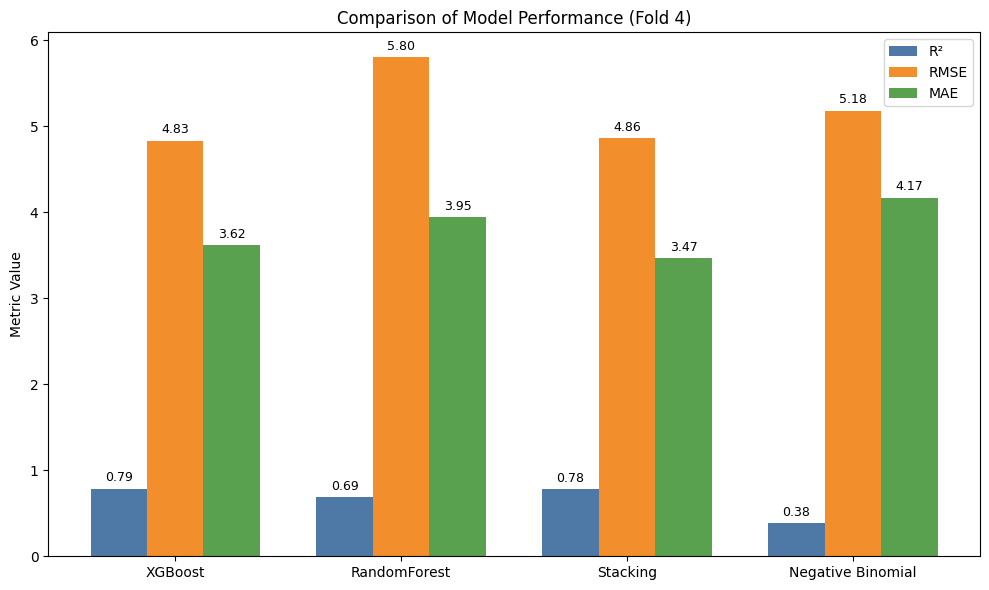

In [86]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 📊 ข้อมูลประเมินโมเดล (Fold 4)
data = {
    'Model': ['XGBoost', 'RandomForest', 'Stacking', 'Negative Binomial'],
    'R²': [0.7853, 0.6904, 0.7823, 0.3827],
    'RMSE': [4.8312, 5.8022, 4.8647, 5.1817],
    'MAE': [3.6212, 3.9473, 3.4652, 4.1716]
}
df = pd.DataFrame(data)

# ⚙️ กำหนด layout
x = np.arange(len(df['Model']))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x - width, df['R²'], width, label='R²', color='#4e79a7')
bar2 = ax.bar(x, df['RMSE'], width, label='RMSE', color='#f28e2b')
bar3 = ax.bar(x + width, df['MAE'], width, label='MAE', color='#59a14f')

# 📝 ใส่ตัวเลขบนแท่ง
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.05,
                f'{yval:.2f}', ha='center', va='bottom', fontsize=9)

add_labels(bar1)
add_labels(bar2)
add_labels(bar3)

# 🧭 ปรับแต่งแกนและชื่อ
ax.set_xticks(x)
ax.set_xticklabels(df['Model'], rotation=0)
ax.set_ylabel('Metric Value')
ax.set_title('Comparison of Model Performance (Fold 4)')
ax.legend()

plt.tight_layout()
plt.show()


กราฟโชซ์ว่าทำไมต้อง40

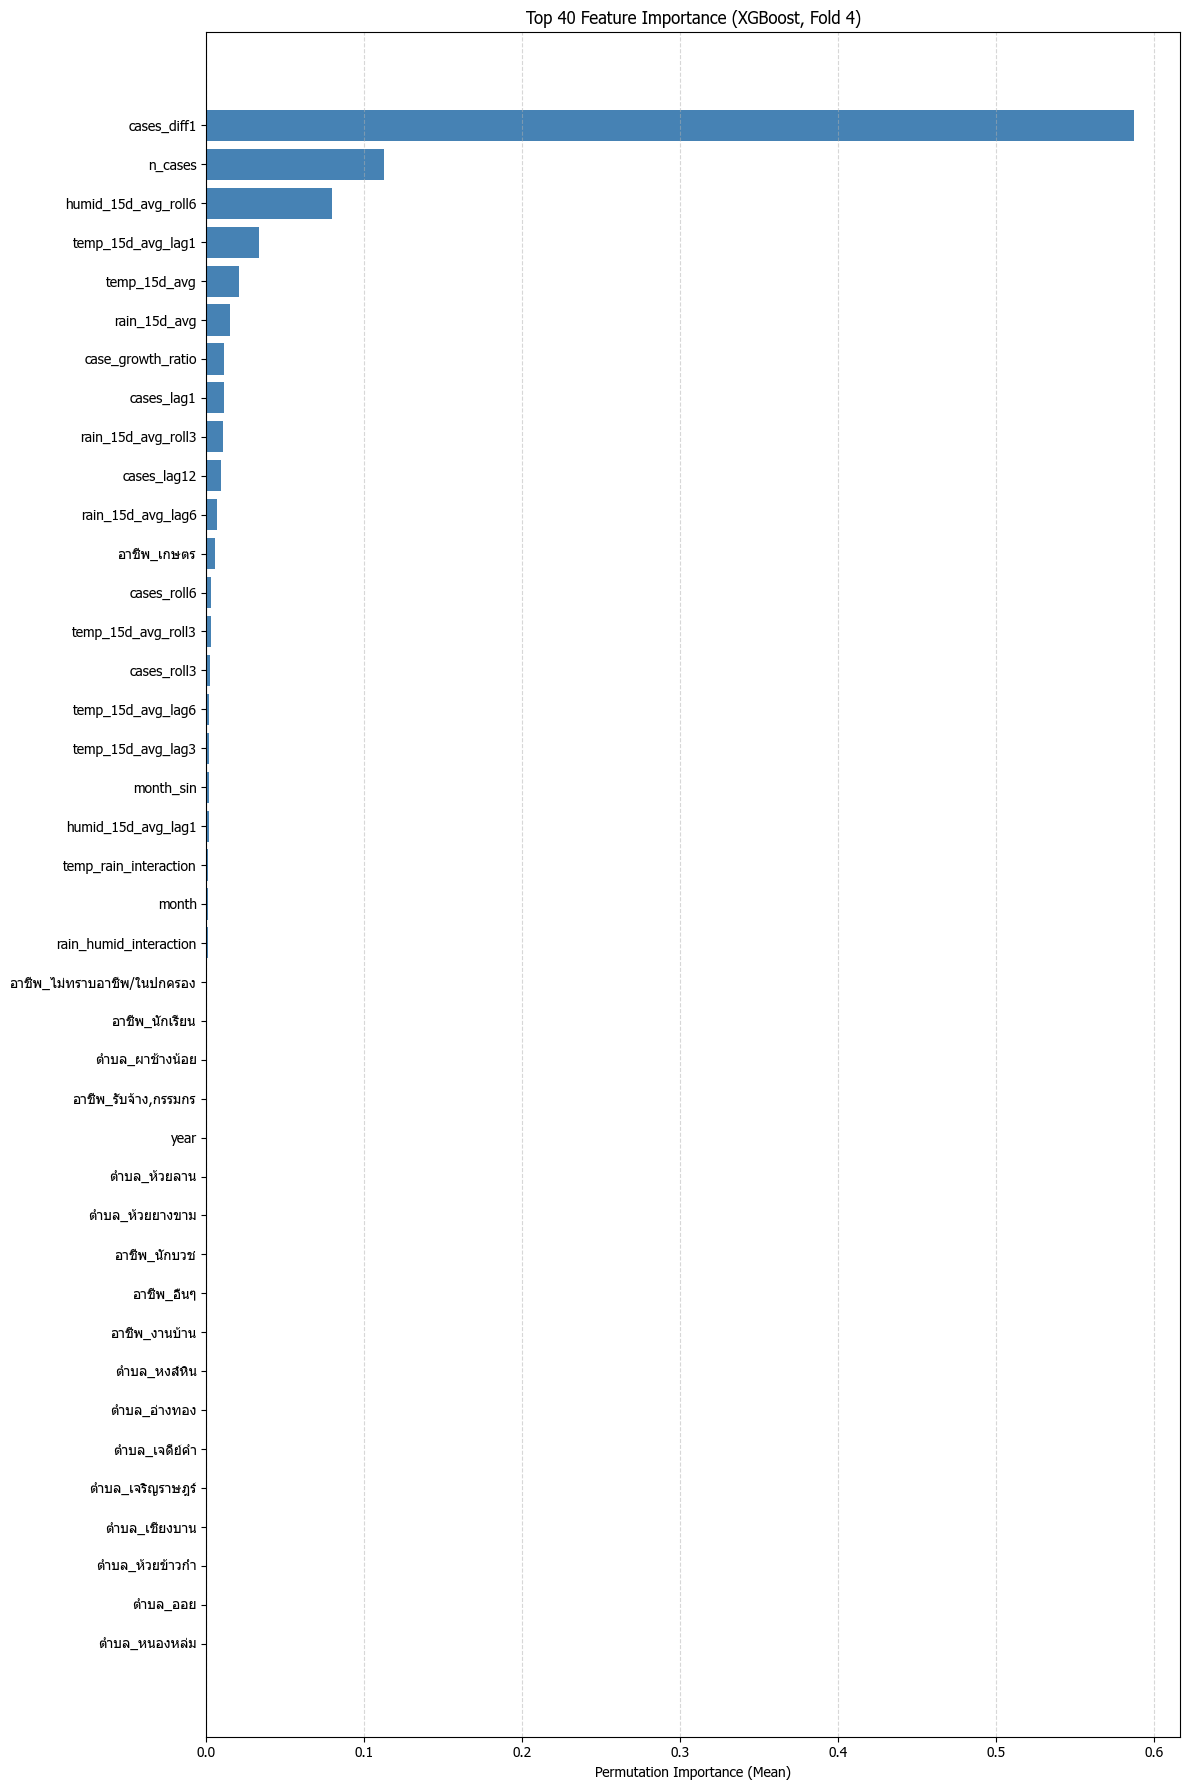

In [89]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import font_manager

# ✅ ติดตั้งฟอนต์ภาษาไทย (เช่น TH Sarabun) ถ้ายังไม่มี
# !apt-get install fonts-thai-tlwg -y   # สำหรับ Google Colab (ถ้าใช้)
# หรือใน Windows ให้ใช้ฟอนต์ 'Tahoma' ก็ได้

plt.rcParams['font.family'] = 'Tahoma'   # หรือ 'TH Sarabun New' ถ้ามี
plt.rcParams['axes.unicode_minus'] = False

# -----------------------------
# เตรียมข้อมูล Top 40 feature
# -----------------------------
top_importances = perm.importances_mean[imp_order][:40]
top_features = X.columns[imp_order][:40]

indices = np.argsort(top_importances)
sorted_features = np.array(top_features)[indices]
sorted_importances = top_importances[indices]

# -----------------------------
# 📊 Plot กราฟแนวนอน
# -----------------------------
plt.figure(figsize=(12, 18))   # ✅ ปรับให้กว้างและสูงขึ้น
bars = plt.barh(sorted_features, sorted_importances, color='steelblue')

plt.xlabel("Permutation Importance (Mean)")
plt.title("Top 40 Feature Importance (XGBoost, Fold 4)")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


📊 Correlation BEFORE Feature Engineering
cases               1.000000
n_cases             0.743534
ตำบล_ป่าแฝก         0.352129
อำเภอ_แม่ใจ         0.178584
ตำบล_อ่างทอง        0.117711
temp_15d_avg        0.106349
อาชีพ_นักเรียน      0.101642
อำเภอ_เชียงคำ       0.101546
ตำบล_ฝายกวาง        0.092547
ตำบล_ท่าจำปี        0.084237
ตำบล_หนองหล่ม       0.083905
year                0.074741
ตำบล_เจริญราษฎร์    0.067595
ตำบล_เชียงม่วน      0.067490
อาชีพ_เกษตร         0.061013
ตำบล_แม่ลาว         0.057976
ตำบล_ผาช้างน้อย     0.050873
rain_15d_avg        0.047043
ตำบล_ร่มเย็น        0.025978
ตำบล_น้ำแวน         0.024990
Name: cases, dtype: float64

📈 Correlation AFTER Feature Engineering
cases                     1.000000
n_cases                   0.718547
cases_diff1               0.609573
temp_15d_avg_lag1         0.360048
อาชีพ_นักเรียน            0.312701
temp_rain_interaction     0.297272
rain_15d_avg              0.288260
rain_humid_interaction    0.275211
ตำบล_ฝายกวาง              0.25

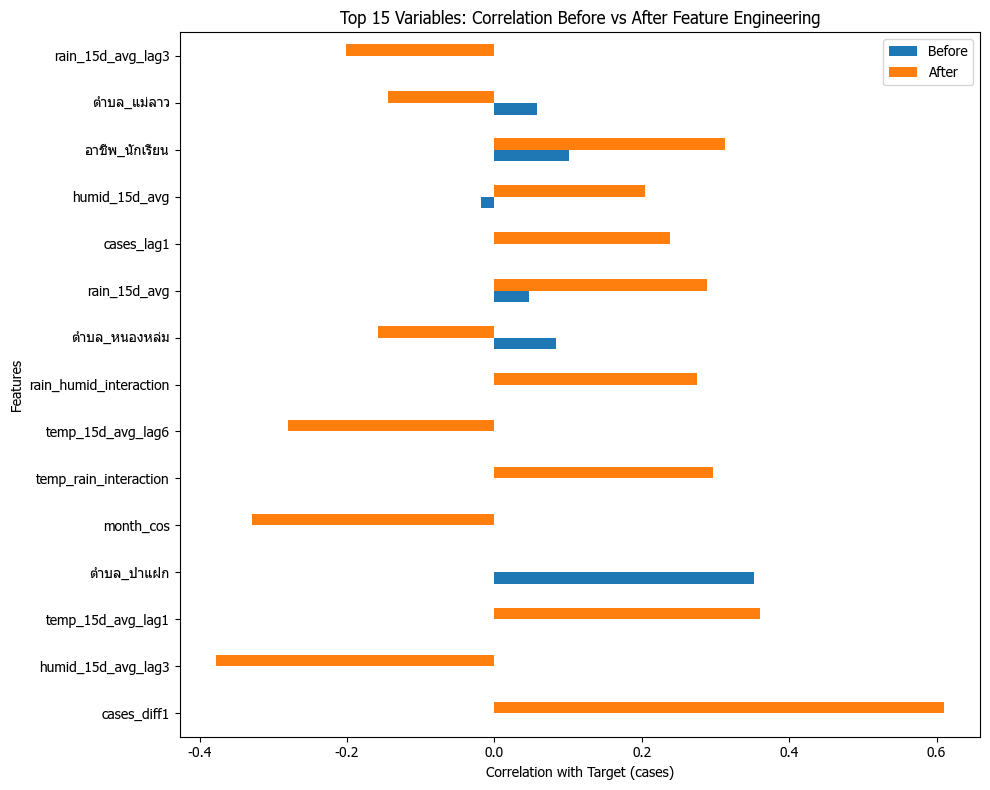

In [99]:
# ======================================
# ✅ Compare Correlation: Before vs After Feature Engineering
# ======================================
import pandas as pd
import numpy as np

# -----------------------------
# 1. 🟡 BEFORE: Raw Variables
# -----------------------------
df_raw = pd.read_excel("df_final_clean.xlsx")
df_raw['date'] = pd.to_datetime(df_raw['date'])
df_raw['year'] = df_raw['date'].dt.year
df_raw['month'] = df_raw['date'].dt.month
df_raw['quarter'] = df_raw['date'].dt.quarter

# 🔸 รวม baseline รายเดือน/ตำบล
df_raw_agg = df_raw.groupby(
    ['อำเภอ','ตำบล','year','month','quarter']
).agg({
    'cases': 'sum',
    'temp_15d_avg': 'mean',
    'rain_15d_avg': 'mean',
    'humid_15d_avg': 'mean',
    'เพศ': 'count',
    'อายุ(ปี)': 'mean',
    'อาชีพ': lambda x: x.mode()[0] if not x.mode().empty else 'ไม่ทราบ'
}).rename(columns={'เพศ':'n_cases','อายุ(ปี)':'age_mean'}).reset_index()

# One-hot encoding สำหรับตัวแปร categorical
df_raw_encoded = pd.get_dummies(df_raw_agg, columns=['อาชีพ','อำเภอ','ตำบล'], drop_first=True)

# คำนวณ Correlation (เฉพาะตัวแปรเชิงตัวเลข)
corr_before = df_raw_encoded.corr(numeric_only=True)['cases'].sort_values(ascending=False)

print("📊 Correlation BEFORE Feature Engineering")
print(corr_before.head(20))


# -----------------------------
# 2. 🟢 AFTER: With Feature Engineering
# -----------------------------
df_feat = df_raw_agg.copy().sort_values(['อำเภอ','ตำบล','year','month'])

# ✅ ตัวอย่าง Feature Engineering (เหมือนตอน train)
# Lag ผู้ป่วย
for lag in [1,3,6,12]:
    df_feat[f'cases_lag{lag}'] = df_feat.groupby(['อำเภอ','ตำบล'])['cases'].shift(lag)

# Rolling + Diff
df_feat['cases_roll3'] = df_feat.groupby(['อำเภอ','ตำบล'])['cases'].transform(lambda x: x.shift(1).rolling(3).mean())
df_feat['cases_roll6'] = df_feat.groupby(['อำเภอ','ตำบล'])['cases'].transform(lambda x: x.shift(1).rolling(6).mean())
df_feat['cases_diff1'] = df_feat.groupby(['อำเภอ','ตำบล'])['cases'].diff(1)

# Climate lags
for var in ['temp_15d_avg', 'rain_15d_avg', 'humid_15d_avg']:
    for lag in [1,3,6]:
        df_feat[f'{var}_lag{lag}'] = df_feat.groupby(['อำเภอ','ตำบล'])[var].shift(lag)

# Interaction
df_feat['temp_rain_interaction'] = df_feat['temp_15d_avg'] * df_feat['rain_15d_avg']
df_feat['rain_humid_interaction'] = df_feat['rain_15d_avg'] * df_feat['humid_15d_avg']

# Seasonality (sin-cos)
df_feat['month_sin'] = np.sin(2 * np.pi * df_feat['month']/12)
df_feat['month_cos'] = np.cos(2 * np.pi * df_feat['month']/12)

# One-hot encoding
df_feat_encoded = pd.get_dummies(df_feat, columns=['อาชีพ','อำเภอ','ตำบล'], drop_first=True)
df_feat_encoded = df_feat_encoded.dropna().reset_index(drop=True)

# คำนวณ Correlation (หลังเพิ่มฟีเจอร์)
corr_after = df_feat_encoded.corr(numeric_only=True)['cases'].sort_values(ascending=False)

print("\n📈 Correlation AFTER Feature Engineering")
print(corr_after.head(20))


# -----------------------------
# 3. 🧠 รวมตารางเปรียบเทียบ Before vs After
# -----------------------------
compare_corr = pd.DataFrame({
    'Before': corr_before,
    'After': corr_after
}).fillna(0).sort_values('After', ascending=False)

print("\n📊 🔸 Correlation Comparison (Before vs After)")
print(compare_corr.head(30))   # แสดง 30 ตัวแปรบนสุด

# -----------------------------
# 4. (Optional) Plot เปรียบเทียบ Top ตัวแปรที่เปลี่ยนเยอะ
# -----------------------------
import matplotlib.pyplot as plt

# เลือกตัวแปรที่มีการเปลี่ยนแปลง corr เยอะที่สุด
compare_corr['Diff'] = compare_corr['After'] - compare_corr['Before']
top_diff = compare_corr['Diff'].abs().sort_values(ascending=False).head(15).index
plot_df = compare_corr.loc[top_diff]

plot_df[['Before','After']].plot(kind='barh', figsize=(10,8))
plt.title("Top 15 Variables: Correlation Before vs After Feature Engineering")
plt.xlabel("Correlation with Target (cases)")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


จบบบบบ

เอนโค๊ด เเละค่าคสพ

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt

df_final_clean = pd.read_excel("df_final_clean.xlsx")
df_final_clean_encoded = df_final_clean.copy()

# ✅ 3. แปลง categorical เป็นตัวเลข (ถ้ามี)
for col in df_final_clean_encoded.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    df_final_clean_encoded[col] = le.fit_transform(df_final_clean_encoded[col]).astype(int)

df_final_clean_encoded = df_final_clean_encoded.drop(columns=['date'])
df_final_clean_encoded

,cases,temp_15d_avg,rain_15d_avg,humid_15d_avg,อายุ(ปี),เพศ,อาชีพ,ตำบล,อำเภอ,เดือน,ปี,ไตรมาส,ฤดูกาล
0,1,22.745000,0.000000,74.794444,34.0,0,0,8,1,2,2017,1,2
1,1,27.170000,2.386667,74.827333,13.0,0,10,60,8,4,2017,2,1
2,1,27.786667,2.520000,73.410667,51.0,1,0,60,8,5,2017,2,1
3,1,27.970000,4.253333,73.302667,14.0,1,10,60,8,5,2017,2,1
4,2,28.501333,4.233333,73.984667,58.0,0,9,60,8,5,2017,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,2,22.858571,2.071429,82.036429,20.5,1,6,3,2,12,2024,4,2
1046,2,22.716667,1.933333,81.784000,56.0,0,7,31,2,12,2024,4,2
1047,1,21.687333,1.933333,82.676000,11.0,1,10,15,2,12,2024,4,2
1048,1,21.304667,1.933333,82.992667,41.0,1,7,35,6,12,2024,4,2


In [ ]:
df_final_clean_encoded.corr()['cases'] #ก่อนเพิ่มหลังจากเอนโค๊ด

cases            1.000000
temp_15d_avg     0.100030
rain_15d_avg     0.094145
humid_15d_avg    0.018460
อายุ(ปี)        -0.034136
เพศ              0.007874
อาชีพ            0.088724
ตำบล             0.051749
อำเภอ            0.042857
เดือน           -0.005328
ปี               0.229528
ไตรมาส           0.013666
ฤดูกาล          -0.147233
Name: cases, dtype: float64

In [ ]:
pip install seaborn



  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


อันเก่า

In [ ]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [64]:
# ======================================
# ✅ Cross-Validation 5 Folds → เลือก Fold ที่ดีที่สุด (XGBoost)
# ======================================
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# -----------------------------
# 1. Load & Prepare Data
# -----------------------------
df = pd.read_excel("df_final_clean.xlsx")
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Monthly aggregate
agg_df = df.groupby(['อำเภอ','ตำบล','year','month']).agg({
    'cases':'sum',
    'temp_15d_avg':'mean',
    'rain_15d_avg':'mean',
    'humid_15d_avg':'mean',
    'เพศ':'count',
    'อายุ(ปี)':'mean',
    'อาชีพ': lambda x: x.mode()[0] if not x.mode().empty else 'ไม่ทราบ'
}).rename(columns={'เพศ':'n_cases','อายุ(ปี)':'age_mean'}).reset_index()

# Lag features (หลัก ๆ)
agg_df = agg_df.sort_values(['อำเภอ','ตำบล','year','month']).reset_index(drop=True)
for lag in [1,3,6,12]:
    agg_df[f'cases_lag{lag}'] = agg_df.groupby(['อำเภอ','ตำบล'])['cases'].shift(lag)

# Rolling windows
agg_df['cases_roll3'] = agg_df.groupby(['อำเภอ','ตำบล'])['cases'].transform(lambda x: x.shift(1).rolling(3).mean())
agg_df['cases_roll6'] = agg_df.groupby(['อำเภอ','ตำบล'])['cases'].transform(lambda x: x.shift(1).rolling(6).mean())

# One-hot encoding
agg_df = pd.get_dummies(agg_df, columns=['อำเภอ','ตำบล','อาชีพ'], drop_first=True)
agg_df = agg_df.dropna().reset_index(drop=True)

X = agg_df.drop(columns=['cases'])
y = agg_df['cases']

# -----------------------------
# 2. Cross-Validation (5 Folds)
# -----------------------------
tscv = TimeSeriesSplit(n_splits=5)
cv_results = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = XGBRegressor(
        n_estimators=900, learning_rate=0.035, max_depth=6,
        subsample=0.85, colsample_bytree=0.85,
        min_child_weight=3, gamma=0.1, reg_alpha=0.1, reg_lambda=1,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    cv_results.append({
        "Fold": fold,
        "Train Size": len(train_idx),
        "Test Size": len(test_idx),
        "R²": r2_score(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "MAE": mean_absolute_error(y_test, y_pred)
    })

cv_df = pd.DataFrame(cv_results)
print("\n📊 Cross-validation Results (5 folds):")
print(cv_df)

# -----------------------------
# 3. เลือก Fold ที่ดีที่สุด
# -----------------------------
best_fold_idx = cv_df['R²'].idxmax()
best_fold = cv_df.loc[best_fold_idx]
print("\n✅ Suggested Fold for Final Model:", int(best_fold['Fold']))



📊 Cross-validation Results (5 folds):
   Fold  Train Size  Test Size        R²       RMSE       MAE
0     1          16         12 -0.238760  10.915734  6.585901
1     2          28         12 -0.230729   9.417052  6.904764
2     3          40         12  0.342533   8.940499  7.126646
3     4          52         12  0.544156   7.039914  4.036264
4     5          64         12  0.027765   5.097086  3.121682

✅ Suggested Fold for Final Model: 4


In [ ]:
import joblib
joblib.dump(xgb_model, "xgb_regressor.pkl")
print("✅ Saved new model: xgb_regressor.pkl")


✅ Saved new model: xgb_regressor.pkl


ทำใหม่เทรน


🔹 XGBoost RMSE: 3.12, R²: 0.167, MAE: 2.33
📊 XGBoost CV R² mean: -0.097, std: 0.211
💾 Saved: xgb_regressor.pkl + xgb_features.pkl


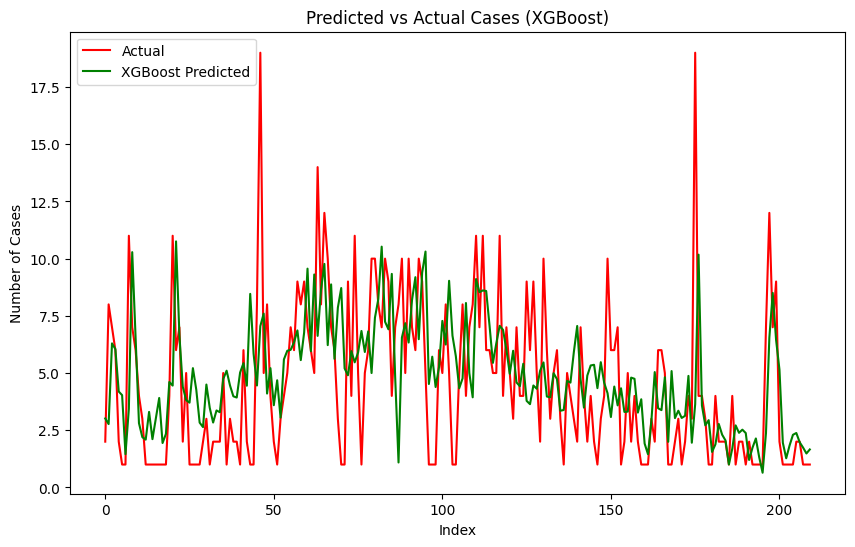

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

# -------------------------------
# 1) เตรียมข้อมูล + lag features
# -------------------------------
df_with_lag = df_final_clean_encoded.copy()
df_with_lag["cases_lag1"] = df_final_clean["cases"].shift(1)
df_with_lag["cases_lag2"] = df_final_clean["cases"].shift(2)
df_with_lag["cases_lag3"] = df_final_clean["cases"].shift(3)
df_with_lag = df_with_lag.dropna().reset_index(drop=True)

X = df_with_lag.drop(columns=["cases", "เพศ", "อายุ(ปี)", "ไตรมาส", "humid_15d_avg"])
y = df_with_lag["cases"]

# -------------------------------
# 2) Train/Test Split (Time Series)
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# -------------------------------
# ฟังก์ชันประเมินผล
# -------------------------------
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"🔹 {name} RMSE: {rmse:.2f}, R²: {r2:.3f}, MAE: {mae:.2f}")
    return {"Model": name, "RMSE": rmse, "R2": r2, "MAE": mae}, y_pred

# -------------------------------
# 3) Train + Evaluate XGBoost
# -------------------------------
xgb_model = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1,
    random_state=42
)

xgb_result, xgb_pred = evaluate_model("XGBoost", xgb_model, X_train, X_test, y_train, y_test)

# Cross-validation (TimeSeriesSplit)
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(xgb_model, X, y, cv=tscv, scoring="r2")
print(f"📊 XGBoost CV R² mean: {cv_scores.mean():.3f}, std: {cv_scores.std():.3f}")

# -------------------------------
# 4) Save XGBoost Model + Features
# -------------------------------
joblib.dump(xgb_model, "xgb_regressor.pkl")
joblib.dump(X.columns.tolist(), "xgb_features.pkl")
print("💾 Saved: xgb_regressor.pkl + xgb_features.pkl")

# -------------------------------
# 5) Visualization
# -------------------------------
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Actual", color="red")
plt.plot(xgb_pred, label="XGBoost Predicted", color="green")
plt.title("Predicted vs Actual Cases (XGBoost)")
plt.xlabel("Index")
plt.ylabel("Number of Cases")
plt.legend()
plt.show()


🔹 XGBoost RMSE: 3.12, R²: 0.167, MAE: 2.33
🔹 RandomForest RMSE: 2.97, R²: 0.245, MAE: 2.24
🔹 Deep Learning RMSE: 3.06, R²: 0.198, MAE: 2.32

📊 Performance Comparison:
           Model      RMSE        R2       MAE
0        XGBoost  3.116279  0.167044  2.330670
1   RandomForest  2.966994  0.244937  2.243819
2  Deep Learning  3.057424  0.198209  2.320110


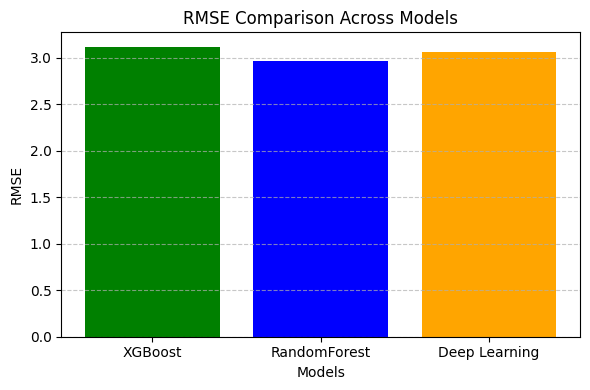

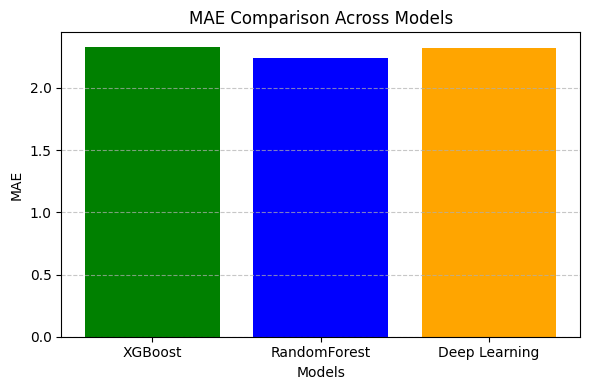

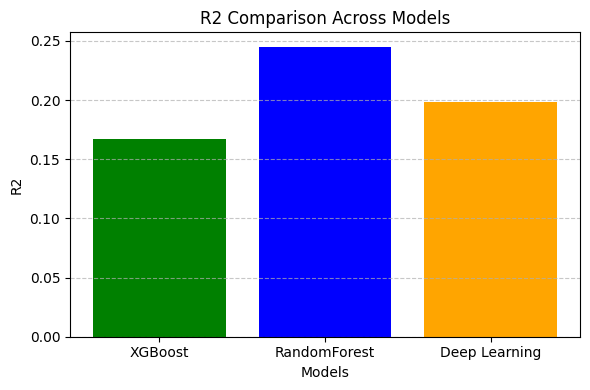

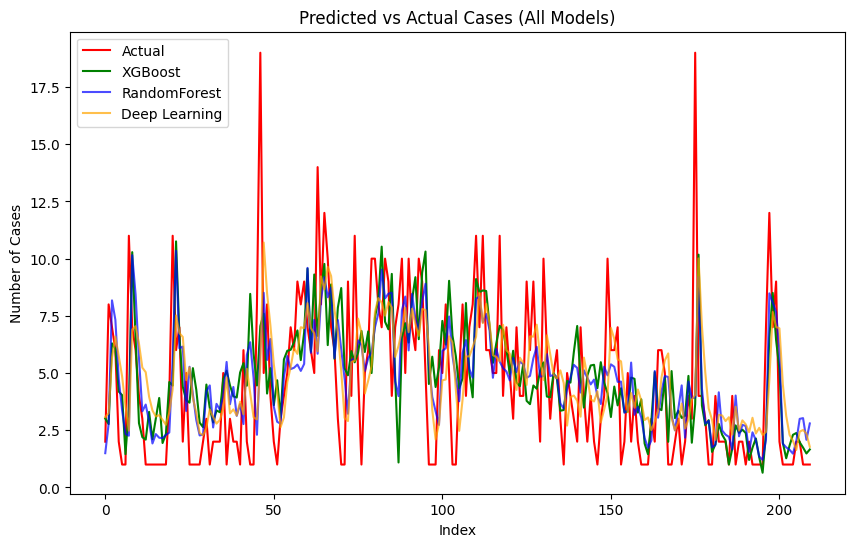

In [ ]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# 1) เตรียมข้อมูล + lag features
# -------------------------------
df_with_lag = df_final_clean_encoded.copy()
df_with_lag["cases_lag1"] = df_final_clean["cases"].shift(1)
df_with_lag["cases_lag2"] = df_final_clean["cases"].shift(2)
df_with_lag["cases_lag3"] = df_final_clean["cases"].shift(3)
df_with_lag = df_with_lag.dropna().reset_index(drop=True)

X = df_with_lag.drop(columns=["cases","เพศ","อายุ(ปี)","ไตรมาส","humid_15d_avg"])
y = df_with_lag["cases"]

# -------------------------------
# 2) Train/Test Split (time series)
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)

# -------------------------------
# ฟังก์ชันประเมินผล
# -------------------------------
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"🔹 {name} RMSE: {rmse:.2f}, R²: {r2:.3f}, MAE: {mae:.2f}")
    return {
        "Model": name,
        "RMSE": rmse,
        "R2": r2,
        "MAE": mae
    }, y_pred

# -------------------------------
# 3) Train + Evaluate Models
# -------------------------------
xgb_model = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1,
    random_state=42
)
xgb_result, xgb_pred = evaluate_model("XGBoost", xgb_model, X_train, X_test, y_train, y_test)

rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=8,
    random_state=42
)
rf_result, rf_pred = evaluate_model("RandomForest", rf_model, X_train, X_test, y_train, y_test)

mlp_model = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    max_iter=500,
    random_state=42
)
mlp_result, mlp_pred = evaluate_model("Deep Learning", mlp_model, X_train, X_test, y_train, y_test)

# -------------------------------
# 4) รวมผลลัพธ์เป็นตาราง
# -------------------------------
results_df = pd.DataFrame([xgb_result, rf_result, mlp_result])
print("\n📊 Performance Comparison:")
print(results_df)

# -------------------------------
# 5) วาดกราฟเปรียบเทียบ (Metric)
# -------------------------------
metrics = ["RMSE", "MAE", "R2"]
for metric in metrics:
    plt.figure(figsize=(6,4))
    plt.bar(results_df["Model"], results_df[metric], color=["green","blue","orange"])
    plt.title(f"{metric} Comparison Across Models")
    plt.ylabel(metric)
    plt.xlabel("Models")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

# -------------------------------
# 6) วาดกราฟ Predicted vs Actual
# -------------------------------
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Actual", color="red")
plt.plot(xgb_pred, label="XGBoost", color="green")
plt.plot(rf_pred, label="RandomForest", color="blue", alpha=0.7)
plt.plot(mlp_pred, label="Deep Learning", color="orange", alpha=0.7)
plt.title("Predicted vs Actual Cases (All Models)")
plt.xlabel("Index")
plt.ylabel("Number of Cases")
plt.legend()
plt.show()


เทียบว่าถ้ามีเลกเเละไม่มี

🔹 XGBoost (No Lag) RMSE: 3.31, R²: 0.060, MAE: 2.40
🔹 XGBoost (Lag Features) RMSE: 3.12, R²: 0.167, MAE: 2.33

📊 Performance Comparison:
                    Model      RMSE        R2       MAE
0        XGBoost (No Lag)  3.311099  0.059641  2.395751
1  XGBoost (Lag Features)  3.116279  0.167044  2.330670


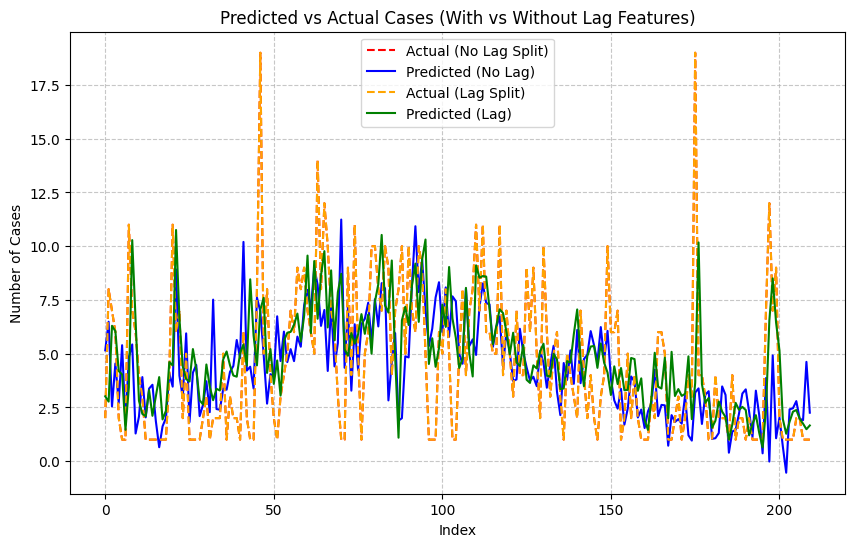

💾 Saved: xgb_regressor.pkl + xgb_features.pkl (Lag Version)


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

# -------------------------------
# ฟังก์ชันประเมินผล
# -------------------------------
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"🔹 {name} RMSE: {rmse:.2f}, R²: {r2:.3f}, MAE: {mae:.2f}")
    return {
        "Model": name,
        "RMSE": rmse,
        "R2": r2,
        "MAE": mae
    }, y_pred

# -------------------------------
# 1) Dataset แบบไม่มี Lag Features
# -------------------------------
X_no_lag = df_final_clean_encoded.drop(columns=["cases","เพศ","อายุ(ปี)","ไตรมาส","humid_15d_avg"])
y_no_lag = df_final_clean["cases"]

X_train_nl, X_test_nl, y_train_nl, y_test_nl = train_test_split(
    X_no_lag, y_no_lag, test_size=0.2, shuffle=False, random_state=42
)

xgb_no_lag = XGBRegressor(
    n_estimators=600, learning_rate=0.05, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, reg_lambda=1,
    random_state=42, objective="reg:squarederror"
)

res_no_lag, y_pred_nl = evaluate_model("XGBoost (No Lag)", xgb_no_lag,
                                       X_train_nl, X_test_nl, y_train_nl, y_test_nl)

# -------------------------------
# 2) Dataset แบบมี Lag Features
# -------------------------------
df_with_lag = df_final_clean_encoded.copy()
df_with_lag["cases_lag1"] = df_final_clean["cases"].shift(1)
df_with_lag["cases_lag2"] = df_final_clean["cases"].shift(2)
df_with_lag["cases_lag3"] = df_final_clean["cases"].shift(3)
df_with_lag = df_with_lag.dropna().reset_index(drop=True)

X_lag = df_with_lag.drop(columns=["cases","เพศ","อายุ(ปี)","ไตรมาส","humid_15d_avg"])
y_lag = df_with_lag["cases"]

X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(
    X_lag, y_lag, test_size=0.2, shuffle=False, random_state=42
)

xgb_lag = XGBRegressor(
    n_estimators=600, learning_rate=0.05, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, reg_lambda=1,
    random_state=42, objective="reg:squarederror"
)

res_lag, y_pred_l = evaluate_model("XGBoost (Lag Features)", xgb_lag,
                                   X_train_l, X_test_l, y_train_l, y_test_l)

# -------------------------------
# 3) รวมผลลัพธ์เปรียบเทียบ
# -------------------------------
results_df = pd.DataFrame([res_no_lag, res_lag])
print("\n📊 Performance Comparison:")
print(results_df)

# -------------------------------
# 4) วาดกราฟเปรียบเทียบ
# -------------------------------
plt.figure(figsize=(10,6))
plt.plot(y_test_nl.values, label="Actual (No Lag Split)", color="red", linestyle="--")
plt.plot(y_pred_nl, label="Predicted (No Lag)", color="blue")
plt.plot(y_test_l.values, label="Actual (Lag Split)", color="orange", linestyle="--")
plt.plot(y_pred_l, label="Predicted (Lag)", color="green")
plt.title("Predicted vs Actual Cases (With vs Without Lag Features)")
plt.xlabel("Index")
plt.ylabel("Number of Cases")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

# -------------------------------
# 5) บันทึกโมเดล Lag (เลือกไว้ใช้จริง)
# -------------------------------
joblib.dump(xgb_lag, "xgb_regressor.pkl")
joblib.dump(X_lag.columns.tolist(), "xgb_features.pkl")
print("💾 Saved: xgb_regressor.pkl + xgb_features.pkl (Lag Version)")


In [ ]:
X

,temp_15d_avg,rain_15d_avg,อาชีพ,ตำบล,อำเภอ,เดือน,ปี,ฤดูกาล,cases_lag1,cases_lag2,cases_lag3
0,27.970000,4.253333,10,60,8,5,2017,1,1.0,1.0,1.0
1,28.501333,4.233333,9,60,8,5,2017,1,1.0,1.0,1.0
2,28.355333,4.253333,9,60,8,5,2017,1,2.0,1.0,1.0
3,28.310000,2.100000,6,60,8,5,2017,1,1.0,2.0,1.0
4,27.778000,15.313333,10,29,5,5,2017,0,1.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
1042,22.858571,2.071429,6,3,2,12,2024,2,1.0,1.0,1.0
1043,22.716667,1.933333,7,31,2,12,2024,2,2.0,1.0,1.0
1044,21.687333,1.933333,10,15,2,12,2024,2,2.0,2.0,1.0
1045,21.304667,1.933333,7,35,6,12,2024,2,1.0,2.0,2.0


ลองทำแบบไม่มีเดือน


ทำแบบกรอก


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import numpy as np
import joblib

# -------------------------------
# 1) เตรียมข้อมูล
# -------------------------------
df = pd.read_excel("df_final_clean.xlsx")
df = df.dropna()

X = df[["temp_15d_avg","rain_15d_avg","อาชีพ","ตำบล","อำเภอ"]]  # ฟีเจอร์ที่ให้ user กรอก
y = df["cases"]

# One-hot หรือ Label Encoding (ถ้ามีตัวแปรหมวดหมู่)
X = pd.get_dummies(X, columns=["อาชีพ","ตำบล","อำเภอ"], drop_first=True)

# -------------------------------
# 2) Train/Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------------------
# 3) Train XGBoost
# -------------------------------
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective="reg:squarederror"
)
model.fit(X_train, y_train)

# -------------------------------
# 4) Evaluate
# -------------------------------
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.2f}, R²: {r2:.3f}, MAE: {mae:.2f}")

# -------------------------------
# 5) Save Model + Features
# -------------------------------
joblib.dump(model, "xgb_regressor_input.pkl")
joblib.dump(X.columns.tolist(), "xgb_features_input.pkl")
print("💾 Saved: xgb_regressor_input.pkl + xgb_features_input.pkl")


RMSE: 3.11, R²: 0.125, MAE: 2.12
💾 Saved: xgb_regressor_input.pkl + xgb_features_input.pkl


เทียบ

🔹 XGBoost RMSE: 3.31, R²: 0.060, MAE: 2.40
🔹 RandomForest RMSE: 3.29, R²: 0.069, MAE: 2.53
🔹 MLPRegressor RMSE: 3.36, R²: 0.032, MAE: 2.69

📊 Performance Comparison:
          Model      RMSE        R2       MAE
0       XGBoost  3.311099  0.059641  2.395751
1  RandomForest  3.294758  0.068899  2.530761
2  MLPRegressor  3.359025  0.032221  2.686103


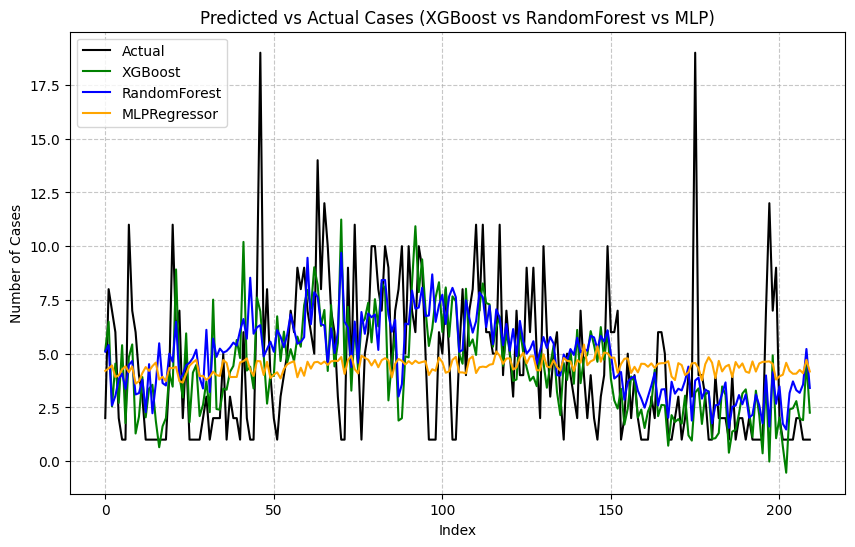

<Figure size 1000x600 with 0 Axes>

C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3620 (\N{THAI CHARACTER RU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3604 (\N{THAI CHARACTER DO DEK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3641 (\N{THAI CHARACTER SARA UU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3585 (\N{THAI CHARACTER KO KAI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3634 (\

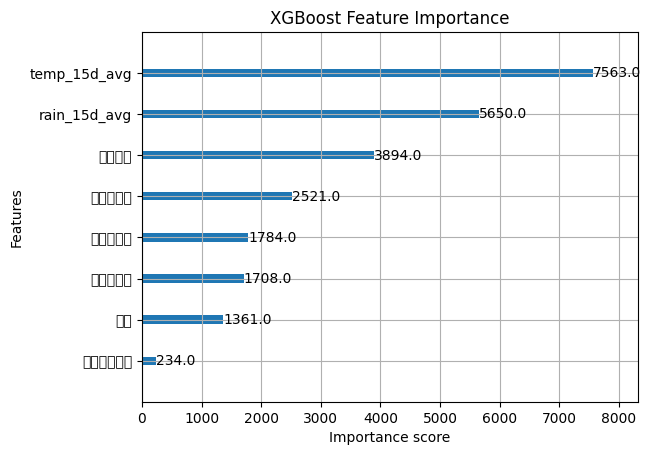

C:\Users\USER\AppData\Local\Temp\ipykernel_4468\3096811674.py:101: UserWarning: Glyph 3629 (\N{THAI CHARACTER O ANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_4468\3096811674.py:101: UserWarning: Glyph 3635 (\N{THAI CHARACTER SARA AM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_4468\3096811674.py:101: UserWarning: Glyph 3648 (\N{THAI CHARACTER SARA E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_4468\3096811674.py:101: UserWarning: Glyph 3616 (\N{THAI CHARACTER PHO SAMPHAO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_4468\3096811674.py:101: UserWarning: Glyph 3611 (\N{THAI CHARACTER PO PLA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_4468\3096811674.py:101: UserWarning: Glyph 3637 (\N{THAI CHARACTER SARA II}) missi

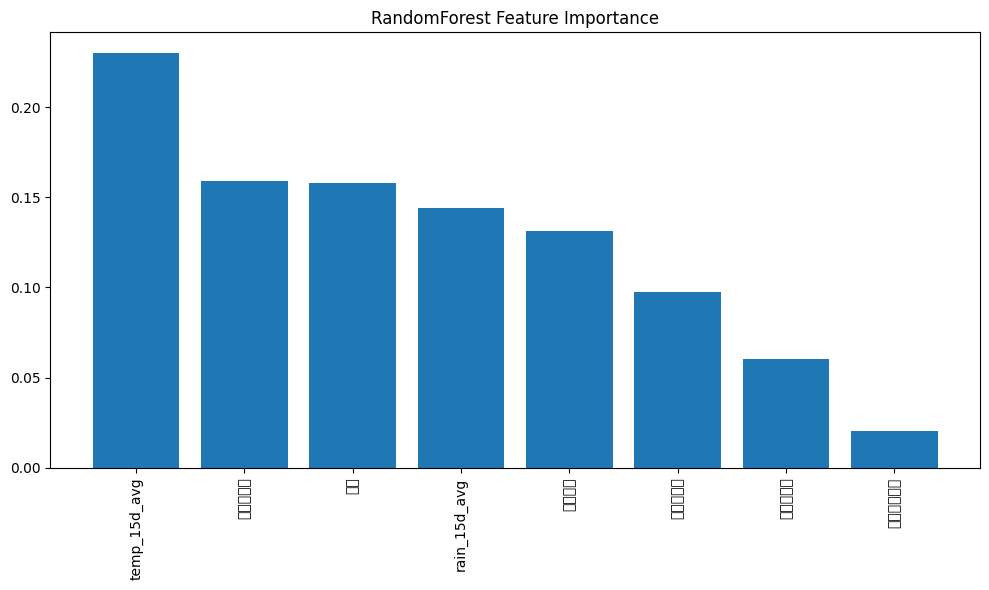

In [ ]:
from xgboost import XGBRegressor, plot_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# 1) เตรียมข้อมูล
# -------------------------------
X_no_lag = df_final_clean_encoded.drop(columns=["cases","เพศ","อายุ(ปี)","ไตรมาส","humid_15d_avg"])
y_no_lag = df_final_clean["cases"]

# -------------------------------
# 2) Train/Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_no_lag, y_no_lag, test_size=0.2, shuffle=False, random_state=42
)

# -------------------------------
# ฟังก์ชันประเมินผล
# -------------------------------
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"🔹 {name} RMSE: {rmse:.2f}, R²: {r2:.3f}, MAE: {mae:.2f}")
    return {"Model": name, "RMSE": rmse, "R2": r2, "MAE": mae}, y_pred, model

# -------------------------------
# 3) XGBoost
# -------------------------------
xgb_model = XGBRegressor(
    n_estimators=600, learning_rate=0.05, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, reg_lambda=1,
    random_state=42, objective="reg:squarederror"
)
xgb_result, xgb_pred, xgb_model = evaluate_model("XGBoost", xgb_model, X_train, X_test, y_train, y_test)

# -------------------------------
# 4) RandomForest
# -------------------------------
rf_model = RandomForestRegressor(
    n_estimators=500, max_depth=12, random_state=42
)
rf_result, rf_pred, rf_model = evaluate_model("RandomForest", rf_model, X_train, X_test, y_train, y_test)

# -------------------------------
# 5) Deep Learning (MLP)
# -------------------------------
mlp_model = MLPRegressor(
    hidden_layer_sizes=(64, 32, 16),
    activation="relu", solver="adam",
    learning_rate_init=0.001, max_iter=1000,
    random_state=42
)
mlp_result, mlp_pred, _ = evaluate_model("MLPRegressor", mlp_model, X_train, X_test, y_train, y_test)

# -------------------------------
# 6) รวมผลลัพธ์เปรียบเทียบ
# -------------------------------
results_df = pd.DataFrame([xgb_result, rf_result, mlp_result])
print("\n📊 Performance Comparison:")
print(results_df)

# -------------------------------
# Visualization: Predicted vs Actual
# -------------------------------
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Actual", color="black")
plt.plot(xgb_pred, label="XGBoost", color="green")
plt.plot(rf_pred, label="RandomForest", color="blue")
plt.plot(mlp_pred, label="MLPRegressor", color="orange")
plt.title("Predicted vs Actual Cases (XGBoost vs RandomForest vs MLP)")
plt.xlabel("Index")
plt.ylabel("Number of Cases")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

# -------------------------------
# 7) Feature Importance
# -------------------------------
# XGBoost Feature Importance
plt.figure(figsize=(10,6))
plot_importance(xgb_model, importance_type="weight", title="XGBoost Feature Importance")
plt.show()

# RandomForest Feature Importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
plt.title("RandomForest Feature Importance")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), X_no_lag.columns[indices], rotation=90)
plt.tight_layout()
plt.show()


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
LSTM → RMSE: 3.16, R²: 0.143, MAE: 2.20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
GRU → RMSE: 3.15, R²: 0.146, MAE: 2.26


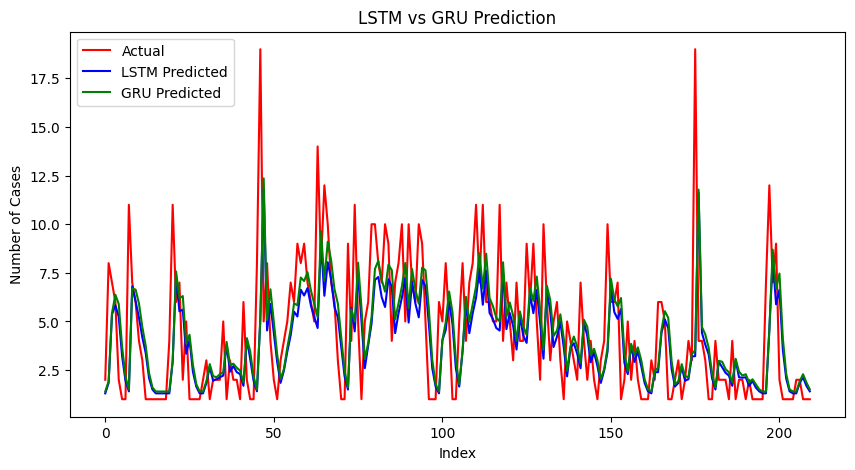

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense

# -------------------------------
# 1) เตรียมข้อมูล (Time Series)
# -------------------------------
df = df_final_clean.copy()   # ใช้ dataset ของคุณ
data = df["cases"].values.reshape(-1,1)

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# กำหนด sequence length (ใช้ข้อมูลย้อนหลัง n วัน/เดือน)
time_steps = 3  

X, y = [], []
for i in range(len(data_scaled) - time_steps):
    X.append(data_scaled[i:i+time_steps])
    y.append(data_scaled[i+time_steps])
X, y = np.array(X), np.array(y)

# Train/Test Split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# -------------------------------
# 2) สร้าง Model LSTM
# -------------------------------
model_lstm = Sequential([
    LSTM(64, activation='tanh', input_shape=(time_steps,1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')

# -------------------------------
# 3) สร้าง Model GRU
# -------------------------------
model_gru = Sequential([
    GRU(64, activation='tanh', input_shape=(time_steps,1)),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse')

# -------------------------------
# 4) Train
# -------------------------------
history_lstm = model_lstm.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
history_gru = model_gru.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

# -------------------------------
# 5) Evaluate
# -------------------------------
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
    y_pred_inv = scaler.inverse_transform(y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    r2 = r2_score(y_test_inv, y_pred_inv)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    print(f"{name} → RMSE: {rmse:.2f}, R²: {r2:.3f}, MAE: {mae:.2f}")
    return y_test_inv, y_pred_inv

y_true_lstm, y_pred_lstm = evaluate_model("LSTM", model_lstm, X_test, y_test)
y_true_gru, y_pred_gru = evaluate_model("GRU", model_gru, X_test, y_test)

# -------------------------------
# 6) Visualization
# -------------------------------
plt.figure(figsize=(10,5))
plt.plot(y_true_lstm, label="Actual", color="red")
plt.plot(y_pred_lstm, label="LSTM Predicted", color="blue")
plt.plot(y_pred_gru, label="GRU Predicted", color="green")
plt.title("LSTM vs GRU Prediction")
plt.xlabel("Index")
plt.ylabel("Number of Cases")
plt.legend()
plt.show()


In [ ]:
 pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.9.23-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.11.3-py3-none-any.whl.metadata (5.9 kB)
  Using cached markdown-3.9-py3-none-any.whl.metadata (5.1 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
  Using cached wheel-0.45.1-py3-none-a

อันเก่า

📊 Comparison of Models (RMSE & MAE):
               Model  RMSE   MAE
0  Gradient Boosting  0.39  0.03
1            XGBoost  0.08  0.01
2      Random Forest  0.39  0.03
3      Deep Learning  0.13  0.10


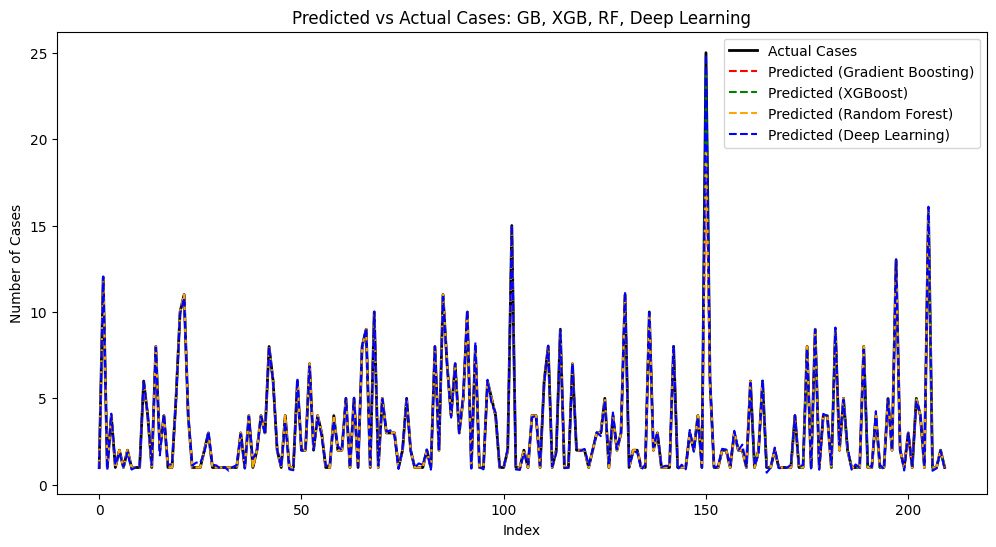

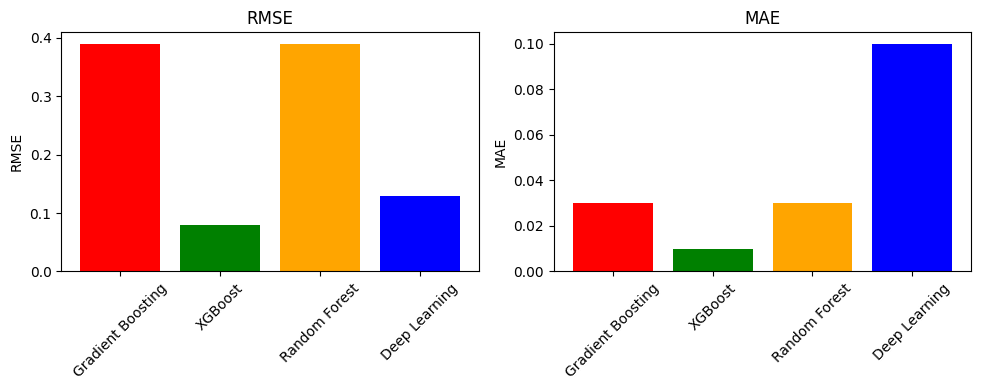

In [ ]:
# ==========================
# 0. Import Libraries
# ==========================
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ==========================
# 1. กำหนด X และ y
# ==========================
X = df_final_clean_encoded.drop(columns=['เพศ','เดือน','อายุ(ปี)','ไตรมาส','humid_15d_avg'])
y = df_final_clean['cases']

# ==========================
# 2. แบ่งชุด train/test
# ==========================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ==========================
# 3. Standardize สำหรับ Deep Learning
# ==========================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==========================
# 4. โมเดล Gradient Boosting
# ==========================
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

# ==========================
# 5. โมเดล XGBoost
# ==========================
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# ==========================
# 6. โมเดล Random Forest
# ==========================
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# ==========================
# 7. โมเดล Deep Learning (MLP)
# ==========================
dl_model = MLPRegressor(hidden_layer_sizes=(64,32), activation='relu', solver='adam',
                        max_iter=500, random_state=42)
dl_model.fit(X_train_scaled, y_train)
y_pred_dl = dl_model.predict(X_test_scaled)

# ==========================
# 8. ประเมินผล RMSE & MAE
# ==========================
models = ['Gradient Boosting', 'XGBoost', 'Random Forest', 'Deep Learning']
preds = [y_pred_gb, y_pred_xgb, y_pred_rf, y_pred_dl]

metrics = []
for name, y_pred in zip(models, preds):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    metrics.append({'Model': name, 'RMSE': round(rmse,2), 'MAE': round(mae,2)})

metrics_df = pd.DataFrame(metrics)
print("📊 Comparison of Models (RMSE & MAE):")
print(metrics_df)

# ==========================
# 9. กราฟ Actual vs Predicted
# ==========================
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Actual Cases', color='black', linewidth=2)
plt.plot(y_pred_gb, label='Predicted (Gradient Boosting)', color='red', linestyle='--')
plt.plot(y_pred_xgb, label='Predicted (XGBoost)', color='green', linestyle='--')
plt.plot(y_pred_rf, label='Predicted (Random Forest)', color='orange', linestyle='--')
plt.plot(y_pred_dl, label='Predicted (Deep Learning)', color='blue', linestyle='--')
plt.title('Predicted vs Actual Cases: GB, XGB, RF, Deep Learning')
plt.xlabel('Index')
plt.ylabel('Number of Cases')
plt.legend()
plt.show()

# ==========================
# 10. Bar chart RMSE & MAE
# ==========================
plt.figure(figsize=(10,4))
metrics_list = ['RMSE','MAE']
colors = ['red','green','orange','blue']

for i, metric in enumerate(metrics_list):
    plt.subplot(1,2,i+1)
    plt.bar(metrics_df['Model'], metrics_df[metric], color=colors)
    plt.title(metric)
    plt.ylabel(metric)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


🔹 XGBoost → RMSE: 3.13, R²: 0.159, MAE: 2.30
🔹 RandomForest → RMSE: 3.05, R²: 0.202, MAE: 2.27


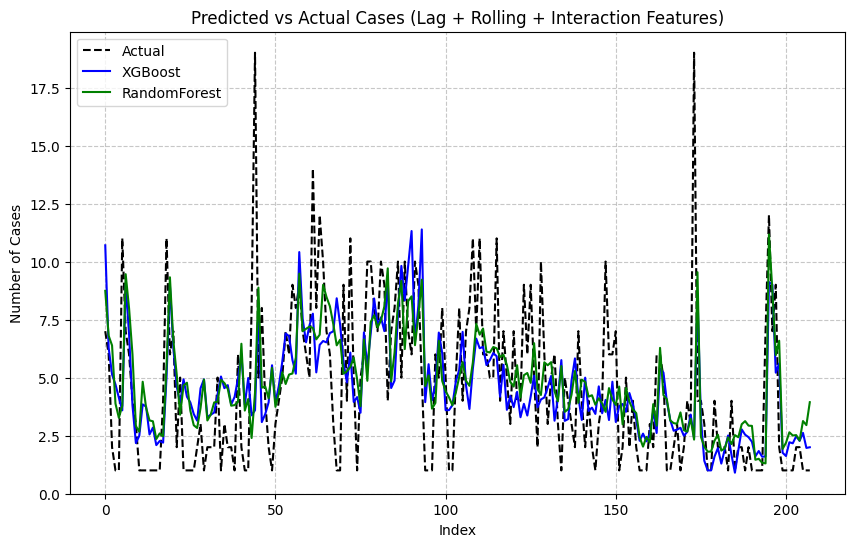

📊 XGBoost CV R²: -0.075 (+/- 0.274)
💾 Saved: xgb_regressor.pkl + xgb_features.pkl


In [ ]:
# -------------------------------
# 📦 Import Libraries
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

# -------------------------------
# 📂 Load data
# -------------------------------
df = pd.read_excel("df_final_clean.xlsx")
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

# -------------------------------
# ⏳ Feature Engineering
# -------------------------------
# lag features (ย้อนหลัง 1–12 เดือน)
for lag in range(1, 13):
    df[f"cases_lag{lag}"] = df["cases"].shift(lag)

# rolling mean ของเคสย้อนหลัง 3,6,12 เดือน
df["cases_roll3"] = df["cases"].shift(1).rolling(3).mean()
df["cases_roll6"] = df["cases"].shift(1).rolling(6).mean()
df["cases_roll12"] = df["cases"].shift(1).rolling(12).mean()

# seasonality features
df["month_sin"] = np.sin(2*np.pi*df["month"]/12)
df["month_cos"] = np.cos(2*np.pi*df["month"]/12)

# interaction feature
df["temp_rain_interact"] = df["temp_15d_avg"] * df["rain_15d_avg"]

# ลบ NA หลังสร้าง lag/rolling
df = df.dropna().reset_index(drop=True)

# -------------------------------
# 🎯 Features & Target
# -------------------------------
selected_features = [
    "temp_15d_avg", "rain_15d_avg", "humid_15d_avg",
    "cases_lag1","cases_lag2","cases_lag3","cases_lag6","cases_lag12",
    "cases_roll3","cases_roll6","cases_roll12",
    "month_sin","month_cos","year",
    "temp_rain_interact"
]

X = df[selected_features]
y = df["cases"]

# -------------------------------
# 🔀 Train/Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# -------------------------------
# 📊 Evaluate Function
# -------------------------------
def evaluate_model(name, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"🔹 {name} → RMSE: {rmse:.2f}, R²: {r2:.3f}, MAE: {mae:.2f}")
    return y_pred, model

# -------------------------------
# 🚀 Train Models
# -------------------------------
xgb_model = XGBRegressor(
    n_estimators=1500, learning_rate=0.01, max_depth=6,
    subsample=0.7, colsample_bytree=0.8,
    reg_lambda=2, reg_alpha=1,
    random_state=42, objective="reg:squarederror"
)
rf_model = RandomForestRegressor(
    n_estimators=1000, max_depth=15, random_state=42
)

y_pred_xgb, xgb_fitted = evaluate_model("XGBoost", xgb_model)
y_pred_rf, rf_fitted = evaluate_model("RandomForest", rf_model)

# -------------------------------
# 📈 Plot results
# -------------------------------
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Actual", color="black", linestyle="--")
plt.plot(y_pred_xgb, label="XGBoost", color="blue")
plt.plot(y_pred_rf, label="RandomForest", color="green")
plt.title("Predicted vs Actual Cases (Lag + Rolling + Interaction Features)")
plt.xlabel("Index")
plt.ylabel("Number of Cases")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

# -------------------------------
# 🔍 Cross Validation (XGBoost)
# -------------------------------
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(
    xgb_model, X, y, cv=tscv, scoring="r2"
)
print(f"📊 XGBoost CV R²: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")

# -------------------------------
# 💾 Save Best Model (XGB)
# -------------------------------
joblib.dump(xgb_fitted, "xgb_regressor.pkl")
joblib.dump(selected_features, "xgb_features.pkl")
print("💾 Saved: xgb_regressor.pkl + xgb_features.pkl")


🔹 XGBoost → RMSE: 3.19, R²: 0.126, MAE: 2.39
🔹 RandomForest → RMSE: 3.16, R²: 0.143, MAE: 2.38
🔹 MLPRegressor → RMSE: 3.04, R²: 0.210, MAE: 2.24


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
🔹 LSTM → RMSE: 3.03, R²: 0.211, MAE: 2.29

📊 Performance Comparison:
          Model      RMSE        R2       MAE
0       XGBoost  3.192104  0.126015  2.386749
1  RandomForest  3.161647  0.142614  2.384627
2  MLPRegressor  3.035190  0.209829  2.240281
3          LSTM  3.032895  0.211023  2.286509


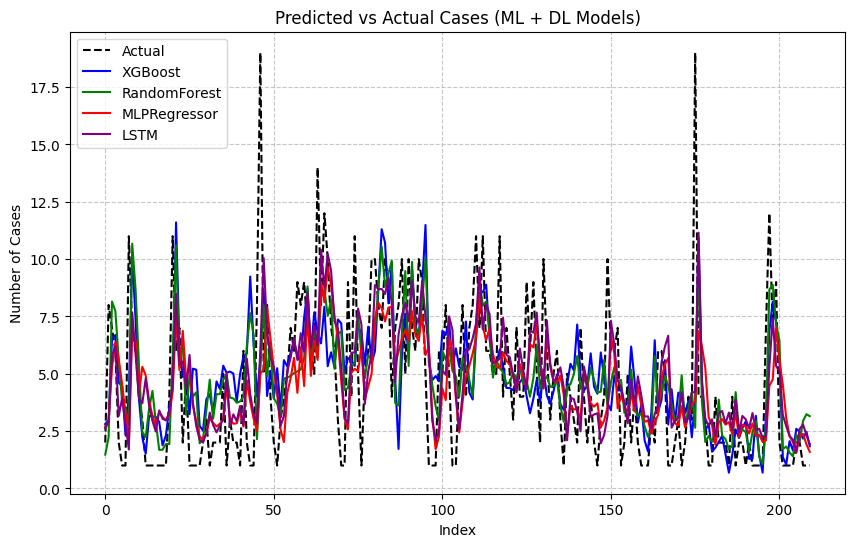

💾 Saved: xgb_regressor.pkl + xgb_features.pkl


In [ ]:
# train_model.py
# -------------------------------
# 📦 Import Libraries
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# -------------------------------
# 📂 Load Data
# -------------------------------
df = pd.read_excel("df_final_clean.xlsx")
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

# -------------------------------
# 🔄 Encode Categorical
# -------------------------------
categorical_cols = ["อาชีพ", "ตำบล", "อำเภอ", "ฤดูกาล"]
for col in categorical_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))

# -------------------------------
# ⏳ Feature Engineering
# -------------------------------
# lag features (ย้อนหลัง 1–3 เดือน)
for lag in range(1, 4):
    df[f"cases_lag{lag}"] = df["cases"].shift(lag)

# rolling mean ของเคสย้อนหลัง 3 เดือน
df["cases_roll3"] = df["cases"].shift(1).rolling(3).mean()

# seasonality features
df["month_sin"] = np.sin(2*np.pi*df["month"]/12)
df["month_cos"] = np.cos(2*np.pi*df["month"]/12)

# drop NA
df = df.dropna().reset_index(drop=True)

# -------------------------------
# 🎯 Features & Target
# -------------------------------
selected_features = [
    "ปี",
    "temp_15d_avg", "rain_15d_avg",
    "อาชีพ", "ตำบล", "อำเภอ", "ฤดูกาล",
    "cases_lag1","cases_lag2","cases_lag3",
    "cases_roll3",
    "month_sin","month_cos"
]

X = df[selected_features]
y = df["cases"]

# -------------------------------
# 🔀 Train/Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)

# -------------------------------
# 📊 Evaluate Function
# -------------------------------
def evaluate_model(name, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"🔹 {name} → RMSE: {rmse:.2f}, R²: {r2:.3f}, MAE: {mae:.2f}")
    return {"Model": name, "RMSE": rmse, "R2": r2, "MAE": mae}, y_pred, model

# -------------------------------
# 🚀 Train ML Models
# -------------------------------
xgb_model = XGBRegressor(
    n_estimators=1000, learning_rate=0.03, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, reg_lambda=1,
    random_state=42, objective="reg:squarederror"
)
rf_model = RandomForestRegressor(
    n_estimators=1000, max_depth=12, random_state=42
)
mlp_model = MLPRegressor(
    hidden_layer_sizes=(64, 32), activation="relu",
    solver="adam", max_iter=500, random_state=42
)

res_xgb, y_pred_xgb, xgb_fitted = evaluate_model("XGBoost", xgb_model)
res_rf, y_pred_rf, rf_fitted = evaluate_model("RandomForest", rf_model)
res_mlp, y_pred_mlp, mlp_fitted = evaluate_model("MLPRegressor", mlp_model)

# -------------------------------
# 🤖 LSTM (Deep Learning)
# -------------------------------
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# reshape → [samples, timesteps, features]
X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
X_train_lstm, X_test_lstm = train_test_split(
    X_lstm, test_size=0.2, shuffle=False, random_state=42
)
y_train_lstm, y_test_lstm = train_test_split(
    y, test_size=0.2, shuffle=False, random_state=42
)

model_lstm = Sequential()
model_lstm.add(LSTM(64, activation='relu', input_shape=(X_lstm.shape[1], X_lstm.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

history = model_lstm.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=16, verbose=0)

y_pred_lstm = model_lstm.predict(X_test_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm, y_pred_lstm))
r2_lstm = r2_score(y_test_lstm, y_pred_lstm)
mae_lstm = mean_absolute_error(y_test_lstm, y_pred_lstm)
print(f"🔹 LSTM → RMSE: {rmse_lstm:.2f}, R²: {r2_lstm:.3f}, MAE: {mae_lstm:.2f}")

# -------------------------------
# 📊 Compare All
# -------------------------------
results_df = pd.DataFrame([
    res_xgb,
    res_rf,
    res_mlp,
    {"Model": "LSTM", "RMSE": rmse_lstm, "R2": r2_lstm, "MAE": mae_lstm}
])
print("\n📊 Performance Comparison:")
print(results_df)

# -------------------------------
# 📈 Plot Results
# -------------------------------
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Actual", color="black", linestyle="--")
plt.plot(y_pred_xgb, label="XGBoost", color="blue")
plt.plot(y_pred_rf, label="RandomForest", color="green")
plt.plot(y_pred_mlp, label="MLPRegressor", color="red")
plt.plot(y_pred_lstm, label="LSTM", color="purple")
plt.title("Predicted vs Actual Cases (ML + DL Models)")
plt.xlabel("Index")
plt.ylabel("Number of Cases")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

# -------------------------------
# 💾 Save Best Model (XGB + Features)
# -------------------------------
joblib.dump(xgb_fitted, "xgb_regressor.pkl")
joblib.dump(selected_features, "xgb_features.pkl")
print("💾 Saved: xgb_regressor.pkl + xgb_features.pkl")


In [ ]:
# train_model.py
# -------------------------------
# 📦 Import Libraries
# -------------------------------
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor

# -------------------------------
# 📂 Load Data
# -------------------------------
df = pd.read_excel("df_final_clean.xlsx")
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

# -------------------------------
# ⏳ Feature Engineering (lag 1–3)
# -------------------------------
for lag in range(1, 4):
    df[f"cases_lag{lag}"] = df["cases"].shift(lag)

df = df.dropna().reset_index(drop=True)

# -------------------------------
# 🎯 Features & Target
# -------------------------------
selected_features = [
    "temp_15d_avg", "rain_15d_avg",
    "cases_lag1", "cases_lag2", "cases_lag3"
]

X = df[selected_features]
y = df["cases"]

# -------------------------------
# 🔀 Train/Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)

# -------------------------------
# 🚀 Train XGBoost
# -------------------------------
xgb_model = XGBRegressor(
    n_estimators=800, learning_rate=0.05, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, random_state=42,
    objective="reg:squarederror"
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

# -------------------------------
# 📊 Evaluate
# -------------------------------
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"🔹 XGBoost → RMSE: {rmse:.2f}, R²: {r2:.3f}, MAE: {mae:.2f}")

# -------------------------------
# 💾 Save model + features
# -------------------------------
joblib.dump(xgb_model, "xgb_regressor.pkl")
joblib.dump(selected_features, "xgb_features.pkl")
print("💾 Saved: xgb_regressor.pkl + xgb_features.pkl")


🔹 XGBoost → RMSE: 3.40, R²: 0.011, MAE: 2.47
💾 Saved: xgb_regressor.pkl + xgb_features.pkl


In [ ]:
# train_model.py
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor

# -------------------------------
# 📂 Load Data
# -------------------------------
df = pd.read_excel("df_final_clean.xlsx")
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

# -------------------------------
# ⏳ Feature Engineering (lag 1–3)
# -------------------------------
for lag in range(1, 4):
    df[f"cases_lag{lag}"] = df["cases"].shift(lag)

df = df.dropna().reset_index(drop=True)

# -------------------------------
# 🎯 เลือกฟีเจอร์ตาม correlation
# -------------------------------
corr = df.corr(numeric_only=True)["cases"].abs().sort_values(ascending=False)
print("📊 Correlation with cases:\n", corr)

# เลือก top 7 ฟีเจอร์ (ยกเว้น target เอง)
top_features = corr.drop("cases").head(7).index.tolist()
print("✅ Selected features:", top_features)

# -------------------------------
# 🔡 Encoding categorical
# -------------------------------
df_encoded = df.copy()
cat_features = [col for col in top_features if df_encoded[col].dtype == "object"]

for col in cat_features:
    df_encoded[col] = df_encoded[col].astype("category").cat.codes

X = df_encoded[top_features]
y = df_encoded["cases"]

# -------------------------------
# 🔀 Train/Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)

# -------------------------------
# 🚀 Train XGBoost
# -------------------------------
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective="reg:squarederror"
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

# -------------------------------
# 📊 Evaluate
# -------------------------------
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"🔹 XGBoost → RMSE: {rmse:.2f}, R²: {r2:.3f}, MAE: {mae:.2f}")

# -------------------------------
# 💾 Save model + features
# -------------------------------
joblib.dump(xgb_model, "xgb_regressor.pkl")
joblib.dump(top_features, "xgb_features.pkl")
print("💾 Saved: xgb_regressor.pkl + xgb_features.pkl")


📊 Correlation with cases:
 cases            1.000000
cases_lag1       0.573559
cases_lag2       0.423437
cases_lag3       0.308246
ปี               0.226934
year             0.226934
temp_15d_avg     0.099039
rain_15d_avg     0.093032
อายุ(ปี)         0.034282
humid_15d_avg    0.017900
ไตรมาส           0.011275
เดือน            0.008118
month            0.008118
Name: cases, dtype: float64
✅ Selected features: ['cases_lag1', 'cases_lag2', 'cases_lag3', 'ปี', 'year', 'temp_15d_avg', 'rain_15d_avg']
🔹 XGBoost → RMSE: 3.24, R²: 0.102, MAE: 2.41
💾 Saved: xgb_regressor.pkl + xgb_features.pkl


In [ ]:
pip install jinja2


🔹 XGBoost RMSE: 3.12, R²: 0.167, MAE: 2.33
🔹 RandomForest RMSE: 2.97, R²: 0.245, MAE: 2.24
🔹 Deep Learning RMSE: 3.06, R²: 0.198, MAE: 2.32

📊 Performance Comparison:
           Model      RMSE        R2       MAE
0        XGBoost  3.116279  0.167044  2.330670
1   RandomForest  2.966994  0.244937  2.243819
2  Deep Learning  3.057424  0.198209  2.320110


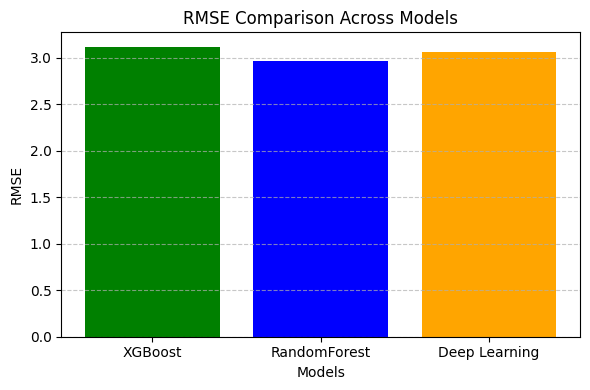

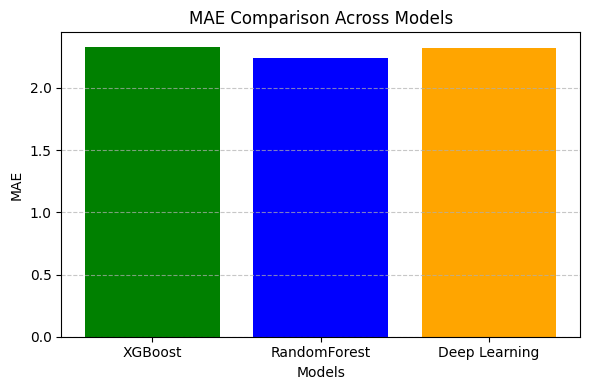

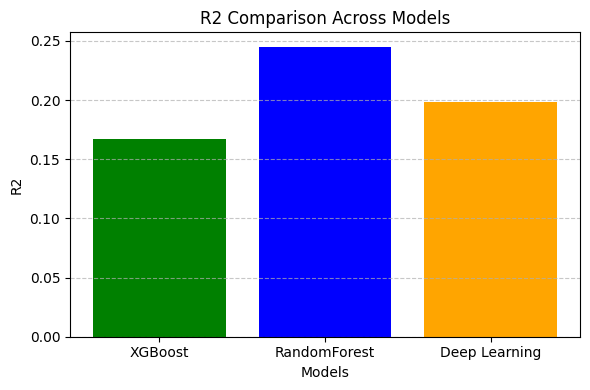

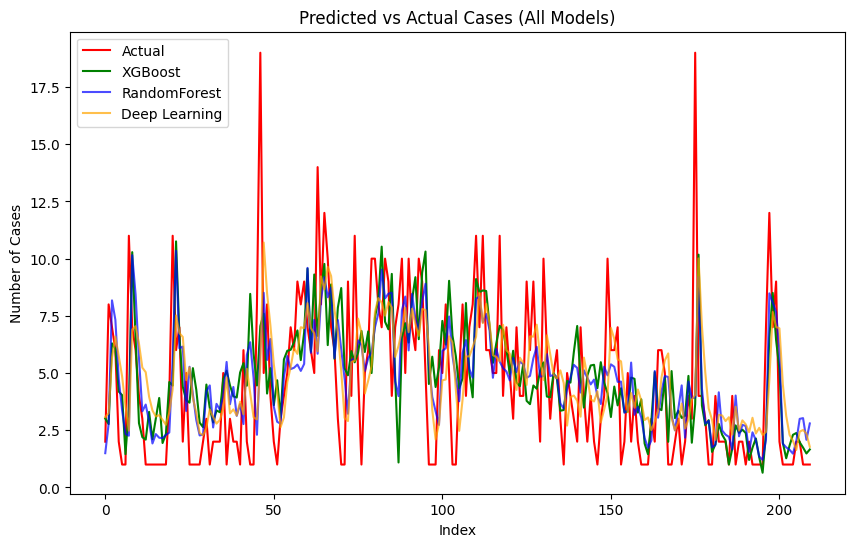

In [ ]:

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# 1) เตรียมข้อมูล + lag features
# -------------------------------
df_with_lag = df_final_clean_encoded.copy()
df_with_lag["cases_lag1"] = df_final_clean["cases"].shift(1)
df_with_lag["cases_lag2"] = df_final_clean["cases"].shift(2)
df_with_lag["cases_lag3"] = df_final_clean["cases"].shift(3)
df_with_lag = df_with_lag.dropna().reset_index(drop=True)

X = df_with_lag.drop(columns=["cases","เพศ","อายุ(ปี)","ไตรมาส","humid_15d_avg"])
y = df_with_lag["cases"]

# -------------------------------
# 2) Train/Test Split (time series)
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)

# -------------------------------
# ฟังก์ชันประเมินผล
# -------------------------------
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"🔹 {name} RMSE: {rmse:.2f}, R²: {r2:.3f}, MAE: {mae:.2f}")
    return {
        "Model": name,
        "RMSE": rmse,
        "R2": r2,
        "MAE": mae
    }, y_pred

# -------------------------------
# 3) Train + Evaluate Models
# -------------------------------
xgb_model = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1,
    random_state=42
)
xgb_result, xgb_pred = evaluate_model("XGBoost", xgb_model, X_train, X_test, y_train, y_test)

rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=8,
    random_state=42
)
rf_result, rf_pred = evaluate_model("RandomForest", rf_model, X_train, X_test, y_train, y_test)

mlp_model = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    max_iter=500,
    random_state=42
)
mlp_result, mlp_pred = evaluate_model("Deep Learning", mlp_model, X_train, X_test, y_train, y_test)

# -------------------------------
# 4) รวมผลลัพธ์เป็นตาราง
# -------------------------------
results_df = pd.DataFrame([xgb_result, rf_result, mlp_result])
print("\n📊 Performance Comparison:")
print(results_df)

# -------------------------------
# 5) วาดกราฟเปรียบเทียบ (Metric)
# -------------------------------
metrics = ["RMSE", "MAE", "R2"]
for metric in metrics:
    plt.figure(figsize=(6,4))
    plt.bar(results_df["Model"], results_df[metric], color=["green","blue","orange"])
    plt.title(f"{metric} Comparison Across Models")
    plt.ylabel(metric)
    plt.xlabel("Models")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

# -------------------------------
# 6) วาดกราฟ Predicted vs Actual
# -------------------------------
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Actual", color="red")
plt.plot(xgb_pred, label="XGBoost", color="green")
plt.plot(rf_pred, label="RandomForest", color="blue", alpha=0.7)
plt.plot(mlp_pred, label="Deep Learning", color="orange", alpha=0.7)
plt.title("Predicted vs Actual Cases (All Models)")
plt.xlabel("Index")
plt.ylabel("Number of Cases")
plt.legend()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import joblib
import numpy as np

# -------------------
# Load Data
# -------------------
df = pd.read_excel("df_final_clean.xlsx")
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

# ------------------- Generate Lag Features -------------------
df = df.sort_values("date").reset_index(drop=True)
for k in [1, 2, 3]:
    df[f"cases_lag{k}"] = df["cases"].shift(k)

df = df.dropna().reset_index(drop=True)

# ------------------- Features -------------------
features = [
    "temp_15d_avg", "rain_15d_avg",
    "year", "month",
    "cases_lag1", "cases_lag2", "cases_lag3",
    "ตำบล", "อำเภอ", "อาชีพ", "ฤดูกาล"
]

X = df[features]
y = df["cases"]

# ------------------- One-hot encode categorical -------------------
cat_cols = ["ตำบล", "อำเภอ", "อาชีพ", "ฤดูกาล"]
enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_cat = enc.fit_transform(X[cat_cols])
X_cat_df = pd.DataFrame(X_cat, columns=enc.get_feature_names_out(cat_cols))

X_num = X.drop(columns=cat_cols).reset_index(drop=True)
X_final = pd.concat([X_num, X_cat_df], axis=1)

# ------------------- Train/Test split -------------------
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# ------------------- Train XGBoost -------------------
xgb_model = XGBRegressor(
    n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42
)
xgb_model.fit(X_train, y_train)

# ------------------- Evaluate -------------------
y_pred = xgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("📊 Model Performance:")
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}")

# ------------------- Save model + features + encoder -------------------
joblib.dump(xgb_model, "xgb_regressor.pkl")
joblib.dump(list(X_final.columns), "xgb_features.pkl")
joblib.dump(enc, "xgb_encoder.pkl")

print("✅ Model trained & saved with categorical encoding + lag features")


📊 Model Performance:
RMSE: 2.54, MAE: 1.70, R²: 0.393
✅ Model trained & saved with categorical encoding + lag features


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import joblib
import numpy as np

# ---------------- Load Data ----------------
df = pd.read_excel("df_final_clean.xlsx")
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

# ---------------- Generate Lag Features ----------------
df = df.sort_values("date").reset_index(drop=True)
for k in [1, 2, 3]:
    df[f"cases_lag{k}"] = df["cases"].shift(k)

df = df.dropna().reset_index(drop=True)

# ---------------- Features ----------------
features = [
    "temp_15d_avg", "rain_15d_avg",
    "year", "month",
    "cases_lag1", "cases_lag2", "cases_lag3",
    "ตำบล", "อำเภอ", "อาชีพ", "ฤดูกาล"
]

X = df[features]
y = df["cases"]

# ---------------- One-hot Encode ----------------
cat_cols = ["ตำบล", "อำเภอ", "อาชีพ", "ฤดูกาล"]
enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_cat = enc.fit_transform(X[cat_cols])
X_cat_df = pd.DataFrame(X_cat, columns=enc.get_feature_names_out(cat_cols))

X_num = X.drop(columns=cat_cols).reset_index(drop=True)
X_final = pd.concat([X_num, X_cat_df], axis=1)

# ---------------- Train/Test Split ----------------
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42
)

# ---------------- Train XGBoost ----------------
xgb_model = XGBRegressor(
    n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42
)
xgb_model.fit(X_train, y_train)

# ---------------- Evaluate ----------------
y_pred = xgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("📊 Model Performance:")
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}")

# ---------------- Save Model ----------------
joblib.dump(xgb_model, "xgb_regressor.pkl")
joblib.dump(list(X_final.columns), "xgb_features.pkl")
joblib.dump(enc, "xgb_encoder.pkl")

print("✅ Model trained & saved with categorical encoding + lag features")


📊 Model Performance:
RMSE: 2.54, MAE: 1.70, R²: 0.393
✅ Model trained & saved with categorical encoding + lag features


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import joblib
import numpy as np

# ---------------- Load Data ----------------
df = pd.read_excel("df_final_clean.xlsx")
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

# ---------------- Generate Lag Features ----------------
df = df.sort_values("date").reset_index(drop=True)
for k in [1, 2, 3]:
    df[f"cases_lag{k}"] = df["cases"].shift(k)

df = df.dropna().reset_index(drop=True)

# ---------------- Features ----------------
features = [
    "temp_15d_avg", "rain_15d_avg",
    "year", "month",
    "cases_lag1", "cases_lag2", "cases_lag3",
    "ตำบล", "อำเภอ", "อาชีพ", "ฤดูกาล"
]

X = df[features]
y = df["cases"]

# ---------------- One-hot Encode ----------------
cat_cols = ["ตำบล", "อำเภอ", "อาชีพ", "ฤดูกาล"]
enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_cat = enc.fit_transform(X[cat_cols])
X_cat_df = pd.DataFrame(X_cat, columns=enc.get_feature_names_out(cat_cols))

X_num = X.drop(columns=cat_cols).reset_index(drop=True)
X_final = pd.concat([X_num, X_cat_df], axis=1)

# ---------------- Train/Test Split ----------------
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42
)

# ======================= Train Models =======================
# 1. XGBoost
xgb_model = XGBRegressor(
    n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# 2. Random Forest
rf_model = RandomForestRegressor(
    n_estimators=300, max_depth=10, random_state=42
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# 3. Deep Learning (MLPRegressor)
mlp_model = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32), activation="relu",
    solver="adam", max_iter=500, random_state=42
)
mlp_model.fit(X_train, y_train)
y_pred_mlp = mlp_model.predict(X_test)

# ======================= Evaluate =======================
def evaluate_model(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n📊 {name} Performance:")
    print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}")
    return rmse, mae, r2

eval_xgb = evaluate_model("XGBoost", y_test, y_pred_xgb)
eval_rf = evaluate_model("Random Forest", y_test, y_pred_rf)
eval_mlp = evaluate_model("Deep Learning (MLP)", y_test, y_pred_mlp)

# ======================= Save Models =======================
joblib.dump(xgb_model, "xgb_regressor.pkl")
joblib.dump(rf_model, "rf_regressor.pkl")
joblib.dump(mlp_model, "mlp_regressor.pkl")
joblib.dump(list(X_final.columns), "xgb_features.pkl")
joblib.dump(enc, "xgb_encoder.pkl")

print("\n✅ All models trained & saved successfully!")



📊 XGBoost Performance:
RMSE: 2.54, MAE: 1.70, R²: 0.393

📊 Random Forest Performance:
RMSE: 2.52, MAE: 1.70, R²: 0.402

📊 Deep Learning (MLP) Performance:
RMSE: 2.70, MAE: 1.67, R²: 0.313

✅ All models trained & saved successfully!


In [ ]:
import joblib
expected_features = joblib.load("xgb_features.pkl")
print(expected_features)


['temp_15d_avg', 'rain_15d_avg', 'อาชีพ', 'ตำบล', 'อำเภอ', 'เดือน', 'ปี', 'ฤดูกาล', 'cases_lag1', 'cases_lag2', 'cases_lag3']
